# Givens Estates 5-yr Monitoring Data Processing
This notebook was made to take in wrangled sediment and water stage timestamp data, then calculate all discharges, sediment loads, and create the necessary output csv's and plots (storm events, rating curves). - SK

In [1]:
# Loads
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment wh ile working

# Reset all rcParams to default values
mpl.rcParams.update(mpl.rcParamsDefault)

# change font to RDE font
# Stolzl Book
plt.rcParams['font.family'] = 'Stolzl'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Stolzl'  # Roman (non-italic) text in math mode
plt.rcParams['mathtext.it'] = 'Stolzl:italic'  # Italic text in math mode
plt.rcParams['mathtext.bf'] = 'Stolzl:bold'  # Bold text in math mode
# Stolzl Medium
# idk
# Knile
# plt.rcParams['font.family'] = 'Knile'
# plt.rcParams['mathtext.fontset'] = 'custom'
# plt.rcParams['mathtext.rm'] = 'Knile'  # Roman (non-italic) text in math mode
# plt.rcParams['mathtext.it'] = 'Knile'  # Italic text in math mode
# plt.rcParams['mathtext.bf'] = 'Knile'  # Bold text in math mode
# fig1, ax1 = plt.subplots()

In [ ]:
# load specific functions from Givens_5-yr_funcs.py file
from Givens_5-yr_funcs import Ce_part_vnotch,  Q_weir_Phil_frankenstein, Q_Bergmann, Q_Sam_frankenstein, Q_Holly_frankenstein

In [2]:
# Load in wrangled data
stage_df = pd.read_excel('Givens_5-yr_DataCombine_SK.xlsx', sheet_name='stage_combine')
stage_df.rename(columns={'date-time': 'date_time_stage'}, inplace=True)
sed_df = pd.read_excel('Givens_5-yr_DataCombine_SK.xlsx', sheet_name='ISCO_combine')

# make sure date_timestamp columns are right data type
stage_df['date_time_stage'] = stage_df['date_time_stage'].values.astype('datetime64[ns]')
sed_df['date_time_ISCO'] = sed_df['Date-Time_ISCO'].values.astype('datetime64[ns]')

# drop any rows where no ISCO timestamp, no sed lab msmts, or no stage or stage timestamp; remove duplicate timestamps (overlap in data)
stage_df = stage_df.dropna(subset=['date_time_stage','stage_corrected_ft'])
sed_df = sed_df.dropna(subset=['date_time_ISCO']) # ,'Vol_Tot_mL', 'Sed_Wt_g' - these might take out rows with ISCO events that haven't received lab results yet
stage_df = stage_df.drop_duplicates(subset='date_time_stage')
sed_df = sed_df.drop_duplicates(subset='date_time_ISCO')

display(stage_df)
display(sed_df)

date_time_stage  stage_raw  stage_corrected_ft
0      2018-04-15 08:23:00     4.0000            0.333333
1      2018-04-15 09:51:00    10.0000            0.833333
2      2018-04-15 10:11:00    19.5000            1.625000
3      2018-04-15 10:20:00    15.5000            1.291667
4      2018-04-15 10:30:00    13.0000            1.083333
...                    ...        ...                 ...
184772 2024-08-20 08:51:13     0.1164            0.116400
184773 2024-08-20 08:56:13     0.1129            0.112900
184774 2024-08-20 09:01:13     0.1090            0.109000
184775 2024-08-20 09:06:13     0.1152            0.115200
184776 2024-08-20 09:11:13     0.1154            0.115400

[143454 rows x 3 columns]

Date-Time_ISCO  Bottle_No_ISCO Lab_Submission_Date Bottle_No_SedLab  \
0   2018-04-15 08:23:00             NaN          2018-04-25      Blue Bottle   
1   2018-04-15 09:51:00             NaN          2018-04-25                3   
2   2018-04-15 10:11:00             NaN          2018-04-25                4   
3   2018-04-15 10:20:00             NaN          2018-04-25                5   
4   2018-04-15 10:30:00             NaN          2018-04-25                6   
..                  ...             ...                 ...              ...   
494 2024-08-17 17:00:00            14.0                 NaT               62   
495 2024-08-17 20:35:00            15.0                 NaT               63   
496 2024-08-17 20:45:00            16.0                 NaT               64   
497 2024-08-17 20:55:00            17.0                 NaT               65   
498 2024-08-17 21:05:00            18.0                 NaT               66   

     Vol_Tot_mL  Sed_Wt_g  Sed_Conc_mg_L  Load_g_s  \
0         380.0    0.1351     355.526316       NaN   
1         453.0    0.7152    1578.807947       NaN   
2         456.0    1.6123    3535.745614       NaN   
3         456.0    3.8201    8377.412281       NaN   
4         460.0    1.5410    3350.000000       NaN   
..          ...       ...            ...       ...   
494         NaN       NaN            NaN       NaN   
495         NaN       NaN            NaN       NaN   
496         NaN       NaN            NaN       NaN   
497         NaN       NaN            NaN       NaN   
498         NaN       NaN            NaN       NaN   

                                                 Notes  Highlight_Excel_ISCO  \
0    couldn't find original ISCO bottle timestamps,...                     0   
1    couldn't find original ISCO bottle timestamps,...                     0   
2    couldn't find original ISCO bottle timestamps,...                     0   
3    couldn't find original ISCO bottle timestamps,...                     0   
4    couldn't find original ISCO bottle timestamps,...                     0   
..                                                 ...                   ...   
494  SedLab data paired to ISCO screen photos; weir...                     0   
495  SedLab data paired to ISCO screen photos; weir...                     0   
496  SedLab data paired to ISCO screen photos; weir...                     0   
497  SedLab data paired to ISCO screen photos; weir...                     0   
498  SedLab data paired to ISCO screen photos; weir...                     0   

     Red_Excel_ISCO      date_time_ISCO  
0                 0 2018-04-15 08:23:00  
1                 0 2018-04-15 09:51:00  
2                 0 2018-04-15 10:11:00  
3                 0 2018-04-15 10:20:00  
4                 0 2018-04-15 10:30:00  
..              ...                 ...  
494               0 2024-08-17 17:00:00  
495               0 2024-08-17 20:35:00  
496               0 2024-08-17 20:45:00  
497               0 2024-08-17 20:55:00  
498               0 2024-08-17 21:05:00  

[464 rows x 12 columns]

In [3]:
# combine dfs - match with nearest timestamp
# Function to find the closest timestamp index - from ChatGPT
def find_closest_time_index(time, df, time_col):
    return (df[time_col] - time).abs().idxmin()

# copy some dataframes to prepare for looping
dummy_stage_df = stage_df.copy()
result_df = stage_df.copy()

# initialize new columns that will be added to stage_df
result_df['date_time_isco'] = pd.NaT
result_df['conc_mg_L'] = np.nan

# Align the dataframes - from ChatGPT
for _, row in sed_df.iterrows():
    closest_index = find_closest_time_index(row['date_time_ISCO'], dummy_stage_df, 'date_time_stage')
    closest_row = dummy_stage_df.loc[closest_index]

    # Update the corresponding row in the result dataframe
    result_df.loc[result_df['date_time_stage'] == closest_row['date_time_stage'], 'date_time_isco'] = row['date_time_ISCO']
    result_df.loc[result_df['date_time_stage'] == closest_row['date_time_stage'], 'conc_mg_L'] = row['Sed_Wt_g']/row['Vol_Tot_mL']*1000**2
    
    # Remove the matched row from dummy_stage_df to avoid repeats
    dummy_stage_df = dummy_stage_df.drop(closest_index)

stage_sed_df = result_df
# take out any error transducer values below anything impossible (eg, weir crest is less than 1ft above weir pool bed upstream)
stage_sed_df = stage_sed_df[stage_sed_df.stage_corrected_ft > -1] 
stage_sed_df.to_csv('stage_sediment_combine.csv', index=False)

In [4]:
min(stage_sed_df.stage_corrected_ft)

-0.16

In [5]:
# look at specific range
stage_sed_df[(stage_sed_df['date_time_stage'] > np.datetime64('2024-08-17 10:00:00')) & (stage_sed_df['date_time_stage'] < np.datetime64('2024-08-17 21:00:00'))]

date_time_stage  stage_raw  stage_corrected_ft      date_time_isco  \
183922 2024-08-17 10:01:13     0.1238              0.1238                 NaT   
183923 2024-08-17 10:06:13     0.1250              0.1250                 NaT   
183924 2024-08-17 10:11:13     0.1227              0.1227                 NaT   
183925 2024-08-17 10:16:13     0.1247              0.1247                 NaT   
183926 2024-08-17 10:21:13     0.1213              0.1213                 NaT   
...                    ...        ...                 ...                 ...   
184049 2024-08-17 20:36:13     0.1470              0.1470 2024-08-17 20:35:00   
184050 2024-08-17 20:41:13     0.2728              0.2728                 NaT   
184051 2024-08-17 20:46:13     0.1960              0.1960 2024-08-17 20:45:00   
184052 2024-08-17 20:51:13     0.3639              0.3639                 NaT   
184053 2024-08-17 20:56:13     0.3116              0.3116 2024-08-17 20:55:00   

        conc_mg_L  
183922        NaN  
183923        NaN  
183924        NaN  
183925        NaN  
183926        NaN  
...           ...  
184049        NaN  
184050        NaN  
184051        NaN  
184052        NaN  
184053        NaN  

[132 rows x 5 columns]

In [7]:
# look at specific range
stage_sed_df[(stage_sed_df['date_time_isco'] > np.datetime64('2024-05-17 15:00:00')) & (stage_sed_df['date_time_isco'] < np.datetime64('2024-05-17 17:00:00'))]

date_time_stage  stage_raw  stage_corrected_ft      date_time_isco  \
128225 2024-05-17 15:27:49     0.4070              0.4070 2024-05-17 15:27:00   
128226 2024-05-17 15:32:49     0.2976              0.2976 2024-05-17 15:32:00   
128228 2024-05-17 15:42:49     0.3735              0.3735 2024-05-17 15:42:00   
128230 2024-05-17 15:52:49     0.3248              0.3248 2024-05-17 15:52:00   
128232 2024-05-17 16:02:49     0.3819              0.3819 2024-05-17 16:02:00   
128234 2024-05-17 16:12:49     0.4020              0.4020 2024-05-17 16:12:00   
128236 2024-05-17 16:22:49     0.3692              0.3692 2024-05-17 16:22:00   
128238 2024-05-17 16:32:49     0.3532              0.3532 2024-05-17 16:32:00   
128240 2024-05-17 16:42:49     0.3525              0.3525 2024-05-17 16:42:00   
128242 2024-05-17 16:52:49     0.3359              0.3359 2024-05-17 16:52:00   

         conc_mg_L  
128225  511.442786  
128226  423.134328  
128228  458.955224  
128230   16.169154  
128232  273.880597  
128234   22.194514  
128236   10.723192  
128238   12.219451  
128240   24.438903  
128242   25.373134

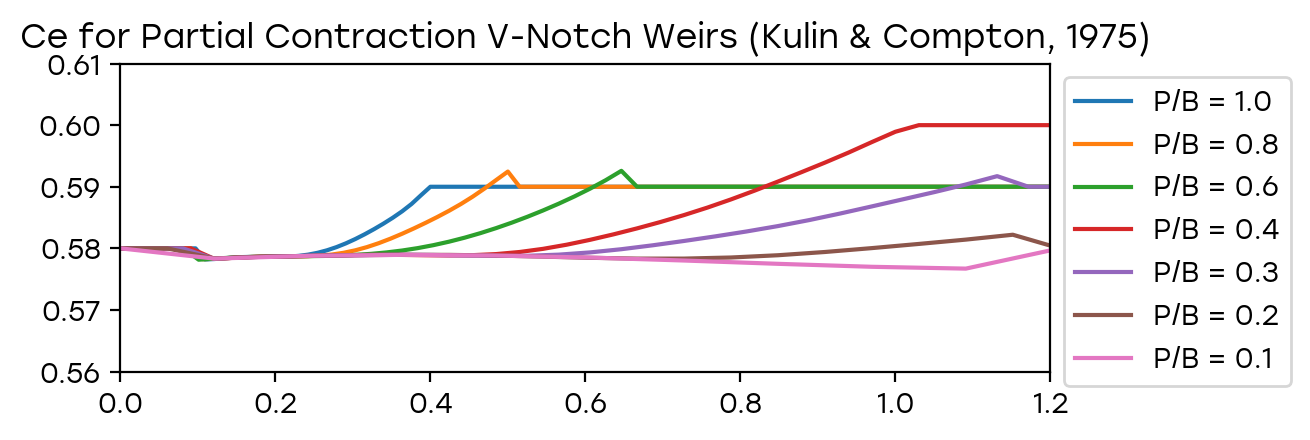

In [9]:
# check Ce plots:
H_arr = np.linspace(0,12,100)

fig, ax = plt.subplots(figsize=(6,2))

# P/B 1.0
P = 10
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot, label='P/B = 1.0')

# P/B 0.8
P = 8
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot, label='P/B = 0.8')

# P/B 0.6
P = 6
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot, label='P/B = 0.6')

# P/B 0.4
P = 4
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot, label='P/B = 0.4')

# P/B 0.3
P = 3
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot, label='P/B = 0.3')

# P/B 0.2
P = 2
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot, label='P/B = 0.2')

# P/B 0.1
P = 1
B = 10
x_plot = H_arr/P
y_plot = np.zeros(len(H_arr))
for i in range(len(H_arr)):
    # print('i = ', i)
    H = H_arr[i]
    y_plot[i] = Ce_part_vnotch(H,P,B)
    # print('Ce = ', y_plot[i])
plt.plot(x_plot, y_plot, label='P/B = 0.1')

# # P/B interpolation checks
# P = 1.5
# B = 10
# x_plot = H_arr/P
# y_plot = np.zeros(len(H_arr))
# for i in range(len(H_arr)):
#     # print('i = ', i)
#     H = H_arr[i]
#     y_plot[i] = Ce_part_vnotch(H,P,B)
#     # print('Ce = ', y_plot[i])
# plt.plot(x_plot, y_plot)

plt.title('Ce for Partial Contraction V-Notch Weirs (Kulin & Compton, 1975)')
plt.xlim([0,1.2])
plt.ylim([0.56,0.61])
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
# plt.savefig('figures/Ce_PartialVNotch_codePlot.pdf')
plt.show()
plt.close()

In [11]:
# calcs

# Givens Estates weir dimensions
P_vnotch = 6/12 # ft, US vertical height of v-crest over US bed
B = 4 # ft, top width of entire weir's lateral span
L_rect = 5.5*2/12 # length of rectangular weir crest portion, not including v-notch horizontal length
Cw = 3.33 # sharp-crested rect weir coefficient
P_rect = 1.5 + 6/12 # ft, US vertical height of rectangular crest over US bed
angle_vnotch = 90 # needs to be in degrees for kh eqn
units_str = 'Imperial' # input unit system for proper coefficients and intercepts - input either 'Imperial' or 'SI'
b = B # width of rectangular section is whole width of channel (sorta like a 'suppressed' or full channel width rectangular weir)

# discharge calcs
stage_sed_df['Q_cfs_PhilFrank'] = Q_weir_Phil_frankenstein(P_vnotch,P_rect,Cw,L_rect,stage_sed_df['stage_corrected_ft'])
stage_sed_df['Q_cfs_Bergmann'] = Q_Bergmann(stage_sed_df['stage_corrected_ft'],P_rect,P_vnotch,units_str,b)
stage_sed_df['Q_cfs_SamFrank'] = Q_Sam_frankenstein(stage_sed_df['stage_corrected_ft'],P_rect,P_vnotch,B,angle_vnotch,units_str,b)
stage_sed_df['Q_cfs_HollyFrank'] = Q_Holly_frankenstein(stage_sed_df['stage_corrected_ft'],P_rect,P_vnotch,B,angle_vnotch)

# sed calcs
# stage_sed_df['Sed_Conc_mg_L'] = stage_sed_df['Sed_Wt_g']/stage_sed_df['Vol_Tot_mL']*1000**2 # concentration from g/mL to mg/L
# ^ conc should be already calculated in combining stage_df and sed_df
stage_sed_df['load_g_s_PhilFrank'] = stage_sed_df['conc_mg_L']*(28.317/1000)*stage_sed_df['Q_cfs_PhilFrank'] # convert mg/L to g/ft^3
stage_sed_df['load_g_s_SamFrank'] = stage_sed_df['conc_mg_L']*(28.317/1000)*stage_sed_df['Q_cfs_SamFrank'] # convert mg/L to g/ft^3
stage_sed_df['load_g_s_HollyFrank'] = stage_sed_df['conc_mg_L']*(28.317/1000)*stage_sed_df['Q_cfs_HollyFrank'] # convert mg/L to g/ft^3

# save df to csv
stage_sed_df.to_csv('stage_sed_flow_combine.csv', index=False)

display(stage_sed_df)


/var/folders/7c/v3tjh_9j0nnfj_5t4k9b4v000000gn/T/ipykernel_12160/776775778.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_sed_df['Q_cfs_PhilFrank'] = Q_weir_Phil_frankenstein(P_vnotch,P_rect,Cw,L_rect,stage_sed_df['stage_corrected_ft'])
/var/folders/7c/v3tjh_9j0nnfj_5t4k9b4v000000gn/T/ipykernel_12160/776775778.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_sed_df['Q_cfs_Bergmann'] = Q_Bergmann(stage_sed_df['stage_corrected_ft'],P_rect,P_vnotch,units_str,b)
/var/folders/7c/v3tjh_9j0nn

date_time_stage  stage_raw  stage_corrected_ft      date_time_isco  \
0      2018-04-15 08:23:00     4.0000            0.333333 2018-04-15 08:23:00   
1      2018-04-15 09:51:00    10.0000            0.833333 2018-04-15 09:51:00   
2      2018-04-15 10:11:00    19.5000            1.625000 2018-04-15 10:11:00   
3      2018-04-15 10:20:00    15.5000            1.291667 2018-04-15 10:20:00   
4      2018-04-15 10:30:00    13.0000            1.083333 2018-04-15 10:30:00   
...                    ...        ...                 ...                 ...   
184772 2024-08-20 08:51:13     0.1164            0.116400                 NaT   
184773 2024-08-20 08:56:13     0.1129            0.112900                 NaT   
184774 2024-08-20 09:01:13     0.1090            0.109000                 NaT   
184775 2024-08-20 09:06:13     0.1152            0.115200                 NaT   
184776 2024-08-20 09:11:13     0.1154            0.115400                 NaT   

          conc_mg_L  Q_cfs_PhilFrank  Q_cfs_Bergmann  Q_cfs_SamFrank  \
0        355.526316         0.162066       -9.066757        0.262660   
1       1578.807947         1.582126       -2.466757        2.570625   
2       3535.745614         8.786380        7.983243       12.782495   
3       8377.412281         4.770895        3.583243        7.666000   
4       3350.000000         3.054466        0.833243        4.943704   
...             ...              ...             ...             ...   
184772          NaN         0.012140      -11.930277        0.019690   
184773          NaN         0.011269      -11.976477        0.018276   
184774          NaN         0.010343      -12.027957        0.016774   
184775          NaN         0.011837      -11.946117        0.019198   
184776          NaN         0.011887      -11.943477        0.019280   

        Q_cfs_HollyFrank  load_g_s_PhilFrank  load_g_s_SamFrank  \
0               0.262660            1.631591           2.644317   
1               2.570625           70.732275         114.925223   
2              13.828894          879.707376        1279.805281   
3               7.666000         1131.766967        1818.553026   
4               4.943704          289.752571         468.969362   
...                  ...                 ...                ...   
184772          0.019690                 NaN                NaN   
184773          0.018276                 NaN                NaN   
184774          0.016774                 NaN                NaN   
184775          0.019198                 NaN                NaN   
184776          0.019280                 NaN                NaN   

        load_g_s_HollyFrank  
0                  2.644317  
1                114.925223  
2               1384.572535  
3               1818.553026  
4                468.969362  
...                     ...  
184772                  NaN  
184773                  NaN  
184774                  NaN  
184775                  NaN  
184776                  NaN  

[143453 rows x 12 columns]

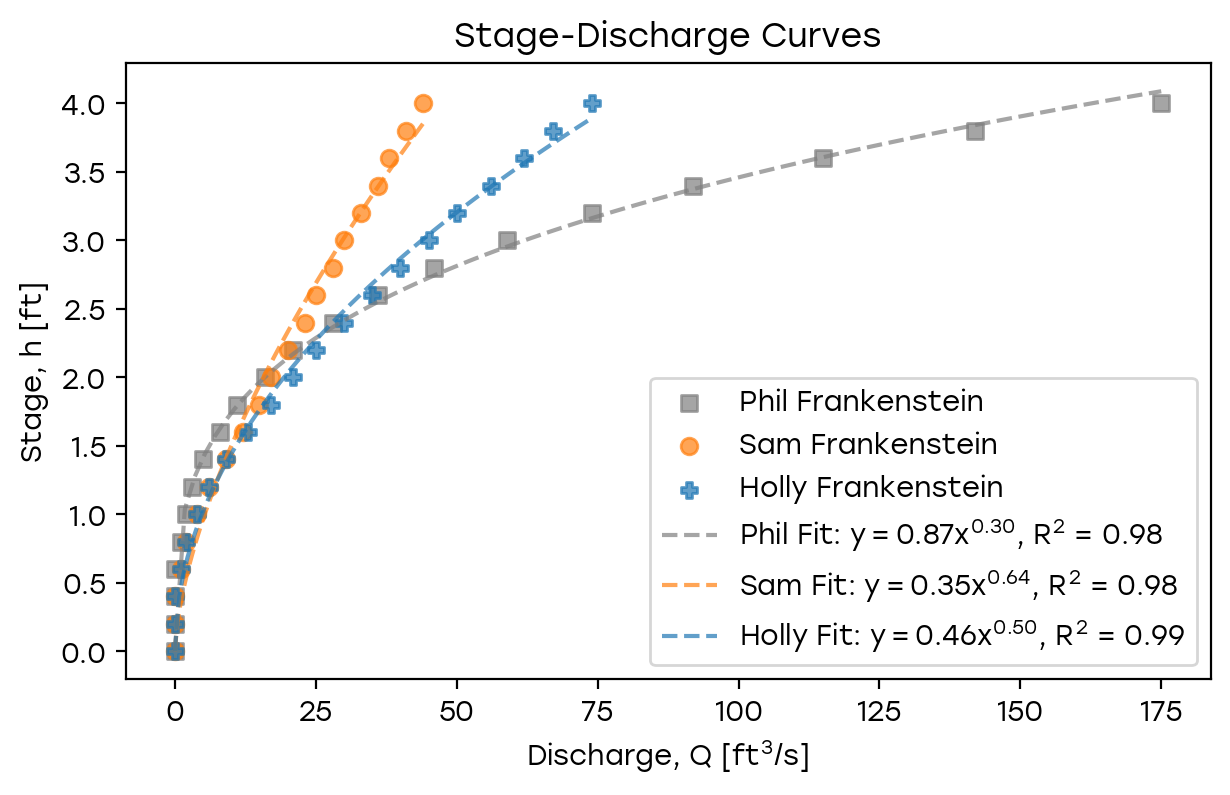

In [14]:
# quick and dirty stage-discharge
from scipy.optimize import curve_fit

# Givens Estates weir dimensions
P_vnotch = 6/12 # ft, US vertical height of v-crest over US bed
B = 4 # ft, top width of entire weir's lateral span
L_rect = 5.5*2/12 # length of rectangular weir crest portion, not including v-notch horizontal length
Cw = 3.33 # sharp-crested rect weir coefficient
P_rect = 1.5 + 6/12 # ft, US vertical height of rectangular crest over US bed
angle_vnotch = 90 # needs to be in degrees for kh eqn
units_str = 'Imperial' # input unit system for proper coefficients and intercepts - input either 'Imperial' or 'SI'
b = B # width of rectangular section is whole width of channel (sorta like a 'suppressed' or full channel width rectangular weir)


stage_plot_arr = np.arange(0,4.2, 0.2)
Q_plot_Phil = Q_weir_Phil_frankenstein(P_vnotch,P_rect,Cw,L_rect,stage_plot_arr)
Q_plot_Sam = Q_Sam_frankenstein(stage_plot_arr,P_rect,P_vnotch,B,angle_vnotch,units_str,b)
Q_plot_Holly = Q_Holly_frankenstein(stage_plot_arr,P_rect,P_vnotch,B,angle_vnotch)

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the power-law function for fitting
def power_law(x, a, b):
    return a * np.power(x, b)

# Function to calculate R-squared
def calculate_r_squared(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# Fit the power-law model to the data
params_Phil, _ = curve_fit(power_law, Q_plot_Phil, stage_plot_arr, maxfev=10000)
params_Sam, _ = curve_fit(power_law, Q_plot_Sam, stage_plot_arr, maxfev=10000)
params_Holly, _ = curve_fit(power_law, Q_plot_Holly, stage_plot_arr, maxfev=10000)

# Generate the best-fit lines
Q_fit_Phil = np.linspace(min(Q_plot_Phil), max(Q_plot_Phil), 100)
Q_fit_Sam = np.linspace(min(Q_plot_Sam), max(Q_plot_Sam), 100)
Q_fit_Holly = np.linspace(min(Q_plot_Holly), max(Q_plot_Holly), 100)

stage_fit_Phil = power_law(Q_fit_Phil, *params_Phil)
stage_fit_Sam = power_law(Q_fit_Sam, *params_Sam)
stage_fit_Holly = power_law(Q_fit_Holly, *params_Holly)

# Calculate R-squared values
r_squared_Phil = calculate_r_squared(stage_plot_arr, power_law(Q_plot_Phil, *params_Phil))
r_squared_Sam = calculate_r_squared(stage_plot_arr, power_law(Q_plot_Sam, *params_Sam))
r_squared_Holly = calculate_r_squared(stage_plot_arr, power_law(Q_plot_Holly, *params_Holly))

# Plot the data points
plt.figure(figsize=(7, 4))
plt.scatter(Q_plot_Phil, stage_plot_arr, marker='s', alpha=0.7, label='Phil Frankenstein', color='tab:gray')
plt.scatter(Q_plot_Sam, stage_plot_arr, marker='o', alpha=0.7, label='Sam Frankenstein', color='tab:orange')
plt.scatter(Q_plot_Holly, stage_plot_arr, marker='P', alpha=0.7, label='Holly Frankenstein', color='tab:blue')

# Plot the best-fit lines
plt.plot(Q_fit_Phil, stage_fit_Phil, alpha=0.7, label=f'Phil Fit: $y = {params_Phil[0]:.2f}x^{{{params_Phil[1]:.2f}}}$, $R^2$ = {r_squared_Phil:.2f}', color='tab:gray', linestyle='--')
plt.plot(Q_fit_Sam, stage_fit_Sam, alpha=0.7, label=f'Sam Fit: $y = {params_Sam[0]:.2f}x^{{{params_Sam[1]:.2f}}}$, $R^2$ = {r_squared_Sam:.2f}', color='tab:orange', linestyle='--')
plt.plot(Q_fit_Holly, stage_fit_Holly, alpha=0.7, label=f'Holly Fit: $y = {params_Holly[0]:.2f}x^{{{params_Holly[1]:.2f}}}$, $R^2$ = {r_squared_Holly:.2f}', color='tab:blue', linestyle='--')

# Customize the plot
plt.xlabel('Discharge, Q [$ft^3/s$]')
plt.ylabel('Stage, h [ft]')
plt.title('Stage-Discharge Curves')
plt.legend()
plt.savefig('figures/stageDischarge_WeirFrankensteins.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


In [15]:
# check when v-notch of weir is overtopped and flow spills onto horizontal crest wings
overtop_df = stage_sed_df[stage_sed_df['stage_corrected_ft'] > 1.5]
overtop_df = overtop_df.dropna(subset=['date_time_isco'])

display(overtop_df)

date_time_stage  stage_raw  stage_corrected_ft      date_time_isco  \
2      2018-04-15 10:11:00  19.500000            1.625000 2018-04-15 10:11:00   
26263  2019-04-19 11:14:47   1.622532            1.652532 2019-04-19 11:15:00   
26443  2019-04-19 14:14:47   1.541340            1.571340 2019-04-19 14:15:00   
26508  2019-04-19 15:19:47   1.689830            1.719830 2019-04-19 15:20:00   
26520  2019-04-19 15:31:47   1.687869            1.717869 2019-04-19 15:32:00   
26541  2019-04-19 15:52:47   1.513539            1.543539 2019-04-19 15:53:00   
26543  2019-04-19 15:54:47   1.527126            1.557126 2019-04-19 15:55:00   
26553  2019-04-19 16:04:47   1.472857            1.502857 2019-04-19 16:05:00   
128540 2024-05-18 17:42:49   1.615300            1.615300 2024-05-18 17:42:00   

          conc_mg_L  Q_cfs_PhilFrank  Q_cfs_Bergmann  Q_cfs_SamFrank  \
2       3535.745614         8.786380        7.983243       12.782495   
26263    860.957179         9.226863        8.346665       13.145918   
26443    951.282051         7.977313        7.274930       12.074183   
26508    844.642857        10.374795        9.234998       14.034251   
26520    991.206030        10.339915        9.209113       14.008366   
26541           NaN         7.584910        6.907957       11.707210   
26543    387.559809         7.774302        7.087305       11.886558   
26553    270.048309         7.048658        6.370955       11.170208   
128540  1212.500000         8.635248        7.855203       12.654455   

        Q_cfs_HollyFrank  load_g_s_PhilFrank  load_g_s_SamFrank  \
2              13.828894          879.707376        1279.805281   
26263          14.357258          224.948385         320.493857   
26443          12.812096          214.888512         325.247756   
26508          15.667602          248.141775         335.667725   
26520          15.629044          290.220529         393.186542   
26541          12.292096                 NaN                NaN   
26543          12.545649           85.319323         130.449401   
26553          11.539602           53.900789          85.418110   
128540         13.643816          296.485741         434.482660   

        load_g_s_HollyFrank  
2               1384.572535  
26263            350.026003  
26443            345.125236  
26508            374.733807  
26520            438.675703  
26541                   NaN  
26543            137.682615  
26553             88.242851  
128540           468.451722

In [16]:
# automate finding sediment events?
# for idx, row in stage_sed_df.iterrows():

# enter sediment events manually:
event_1_start = '2018-04-15 07:50:00'
event_1_end = '2018-04-15 17:00:00'

event_2_start = '2018-04-23 07:00:00'
event_2_end = '2018-04-23 16:30:00'

event_3_start = '2018-04-24 07:00:00'
event_3_end = '2018-04-24 10:30:00'

event_4_start = '2018-04-26 14:00:00'
event_4_end = '2018-04-27 01:00:00'

event_5_start = '2018-05-06 03:00:00'
event_5_end = '2018-05-06 04:30:00'

event_6_start = '2018-05-07 19:00:00'
event_6_end = '2018-05-07 20:10:00'

event_7_start = '2018-05-16 11:00:00'
event_7_end = '2018-05-16 15:00:00'

event_8_start = '2019-04-18 22:50:00'
event_8_end = '2019-04-19 20:00:00'

event_9_start = '2019-07-15 18:00:00'
event_9_end = '2019-07-15 19:30:00'

event_10_start = '2019-07-16 13:00:00'
event_10_end = '2019-07-16 19:00:00'

event_11_start = '2019-07-23 06:30:00'
event_11_end = '2019-07-23 16:00:00'

event_12_start = '2023-07-15 18:00:00'
event_12_end = '2023-07-16 00:00:00'

event_13_start = '2023-08-29 00:00:00'
event_13_end = '2023-08-30 10:00:00'

event_14_start = '2024-05-17 15:00:00'
event_14_end = '2024-05-17 17:20:00' 

event_15_start = '2024-05-18 16:50:00'
event_15_end = '2024-05-18 20:00:00'

event_16_start = '2024-05-23 20:30:00' 
event_16_end = '2024-05-24 00:00:00'

event_17_start = '2024-07-07 13:00:00'
event_17_end = '2024-07-07 18:00:00'

event_18_start = '2024-07-16 18:00:00'
event_18_end = '2024-07-16 20:00:00'

event_19_start = '2024-07-17 20:00:00'
event_19_end = '2024-07-17 22:00:00' 

event_20_start = '2024-07-18 17:00:00'
event_20_end = '2024-07-18 18:00:00' 

event_21_start = '2024-07-24 18:00:00'
event_21_end = '2024-07-25 00:00:00'

event_22_start = '2024-07-19 16:00:00'
event_22_end = '2024-07-19 18:00:00' 

event_23_start = '2024-07-20 17:00:00'
event_23_end = '2024-07-20 21:00:00'

event_24_start = '2024-08-02 14:00:00'
event_24_end = '2024-08-02 17:00:00' 

event_25_start = '2024-08-17 15:00:00' 
event_25_end = '2024-08-17 22:00:00'

events_nested_pairs = np.array([
    [event_1_start,event_1_end],
    [event_2_start,event_2_end],
    [event_3_start,event_3_end],
    [event_4_start,event_4_end],
    [event_5_start,event_5_end],
    [event_6_start,event_6_end],
    [event_7_start,event_7_end],
    [event_8_start,event_8_end],
    [event_9_start,event_9_end],
    [event_10_start,event_10_end],
    [event_11_start,event_11_end],
    [event_12_start,event_12_end],
    [event_13_start,event_13_end],
    [event_14_start,event_14_end],
    [event_15_start,event_15_end],
    [event_16_start,event_16_end],
    [event_17_start,event_17_end],
    [event_18_start,event_18_end],
    [event_19_start,event_19_end],
    [event_20_start,event_20_end],
    [event_21_start,event_21_end],
    [event_22_start,event_22_end],
    [event_23_start,event_23_end],
    [event_24_start,event_24_end],
    [event_25_start,event_25_end],
])

def plot_event_compareQ(stage_sed_df, event_start, event_end):
    # filter master df to only be during event timespan
    event_df = stage_sed_df[(stage_sed_df['date_time_stage'] >= event_start) & (stage_sed_df['date_time_stage'] <= event_end)]
    # make sediment data continuous by dropping stage timestamps it didn't record for
    event_df_sed = event_df.dropna(subset=['conc_mg_L'])
    # display(event_df)
    # Q_trans = Q_Sam_frankenstein((P_rect-P_vnotch),P_rect,P_vnotch,B,angle_vnotch,units_str,b)


    # plot just discharge time series
    fig3, ax1 = plt.subplots()

    # plot discharge vs. sed load with multiple weir equations
    # plot flow on first y-axis
    line1, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_SamFrank'], ls='-', color='tab:blue', alpha=0.7, label='Q Sam') # marker='o'
    line2, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_HollyFrank'], ls='-', color='tab:orange', alpha=0.7, label='Q Holly') # marker='o' # plot old method
    line3, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_PhilFrank'], ls='-', color='tab:grey', alpha=0.5, label='Q Phil') # marker='o' # plot old method
    # ax1.hlines(Q_trans, event_start, event_end, ls = ':', color='tab:purple', alpha=0.7, label='transition triangular to rectangular for Bergmann Frankenstein')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow [cfs]') #, color='tab:blue')
    ax1.tick_params(axis='y') # , labelcolor='tab:blue')
    # Formatting the x-axis to show only the time
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # combine both axes legends into one
    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels)

    plt.xlim([event_start,event_end])
    plt.title('Storm Event {} DISCHARGE'.format(event_start))
    plt.savefig('figures/Hydrograph_discharge_{}_autoscale.pdf'.format(event_start), bbox_inches='tight', pad_inches=0.05)
    plt.show()
    # plt.close()


    # plot discharge vs. sed load time series
    fig1, ax1 = plt.subplots()

    # plot discharge vs. sed load with multiple weir equations
    # plot flow on first y-axis
    # line1, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_SamFrank'], ls='-', color='tab:blue', alpha=0.7, label='Q Sam') # marker='o'
    # line2, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_HollyFrank'], ls='-', color='tab:orange', alpha=0.7, label='Q Holly') # marker='o' # plot old method
    # line3, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_PhilFrank'], ls='-', color='tab:grey', alpha=0.5, label='Q Phil') # marker='o' # plot old method
    line1, = ax1.plot(event_df['date_time_stage'], event_df['Q_cfs_HollyFrank'], ls='-', color='tab:blue', alpha=0.8, label='Discharge')
    # ax1.hlines(Q_trans, event_start, event_end, ls = ':', color='tab:purple', alpha=0.7, label='transition triangular to rectangular for Bergmann Frankenstein')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow [cfs]') #, color='tab:blue')
    ax1.tick_params(axis='y') # , labelcolor='tab:blue')
    # Formatting the x-axis to show only the time
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # plot sediment load on second y-axis
    ax2 = ax1.twinx()
    # line4, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_SamFrank'], ls='--', color='tab:blue', alpha=0.7, label='Qs Sam') # marker='s'
    # line5, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_HollyFrank'], ls='--', color='tab:orange', alpha=0.7, label='Qs Holly') # marker='s'
    # line6, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_PhilFrank'], ls='--', color='tab:grey', alpha=0.5, label='Qs Phil') # marker='s' # plot old method
    line2, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_HollyFrank'], ls='--', color='tab:brown', alpha=0.8, label='Sediment Load')
    ax2.set_ylabel('Load [g/s]') #, color='tab:orange')
    ax2.tick_params(axis='y') # , labelcolor='tab:orange')
    # Formatting the x-axis to show only the time
    ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # combine both axes legends into one
    # lines = [line1, line2, line3, line4, line5, line6]
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels)

    plt.xlim([event_start,event_end])
    plt.title('Storm Event {} LOAD'.format(event_start))
    plt.savefig('figures/Hydrograph_load_{}_autoscale.pdf'.format(event_start), bbox_inches='tight', pad_inches=0.05)
    plt.show()
    # plt.close()


    # plot discharge vs. stage time series
    fig2, ax1 = plt.subplots()

    # plot flow on first y-axis
    line1, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_SamFrank'], ls='-', color='tab:blue', alpha=0.7, label='Q Sam') # marker='o'
    line2, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_HollyFrank'], ls='-', color='tab:orange', alpha=0.7, label='Q Holly') # marker='o' # plot old method
    line3, = ax1.plot(event_df['date_time_stage'],event_df['Q_cfs_PhilFrank'], ls='-', color='tab:grey', alpha=0.5, label='Q Phil') # marker='o' # plot old method
    # ax1.hlines(Q_trans, event_start, event_end, ls = ':', color='tab:purple', alpha=0.7, label='transition triangular to rectangular for Bergmann Frankenstein')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow [cfs]') #, color='tab:blue')
    ax1.tick_params(axis='y') # , labelcolor='tab:blue')
    # Formatting the x-axis to show only the time
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # plot stage on second y-axis
    ax2 = ax1.twinx()
    line4, = ax2.plot(event_df['date_time_stage'],event_df['stage_corrected_ft'], ls='--', color='tab:green', label='Stage') # marker='s'
    ax2.set_ylabel('Stage [ft]') #, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    # Formatting the x-axis to show only the time
    ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # combine both axes legends into one
    lines = [line1, line2, line3, line4]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels)

    plt.xlim([event_start,event_end])
    plt.title('Storm Event {} STAGE-DISCHARGE'.format(event_start))
    plt.savefig('figures/Hydrograph_StageDischarge_{}_autoscale.pdf'.format(event_start), bbox_inches='tight', pad_inches=0.05)
    plt.show()
    # plt.close()
    
    return fig1, fig2, fig3

# for i_event in range(len(events_nested_pairs)):
#     event = events_nested_pairs[i_event]
#     event_start = pd.Timestamp(str(event[0]))
#     event_end = pd.Timestamp(str(event[1]))

#     plot_event_compareQ(stage_sed_df, event_start, event_end)
#     # fig = plot_event(stage_sed_df, event_start, event_end)
#     # plt.show()
#     # plt.close()

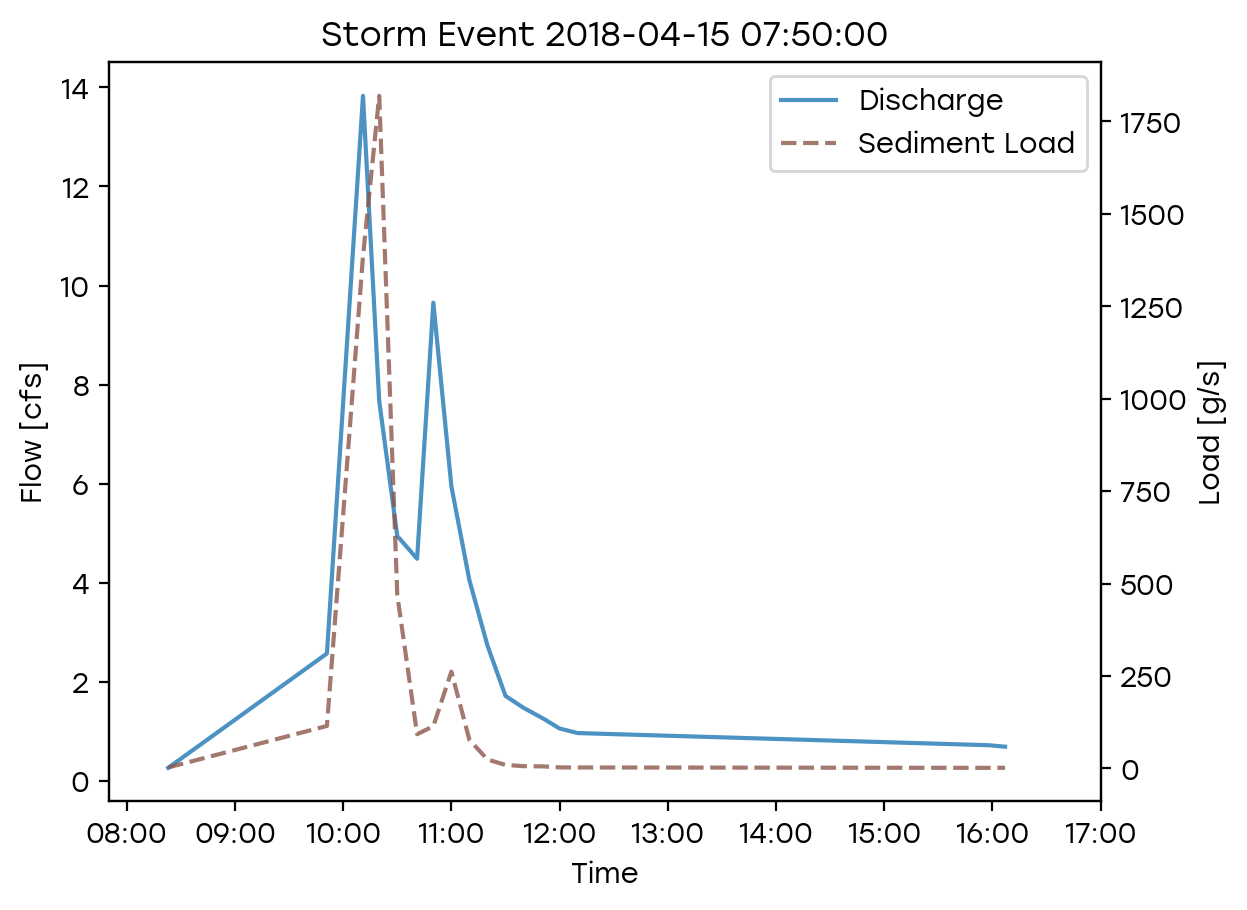

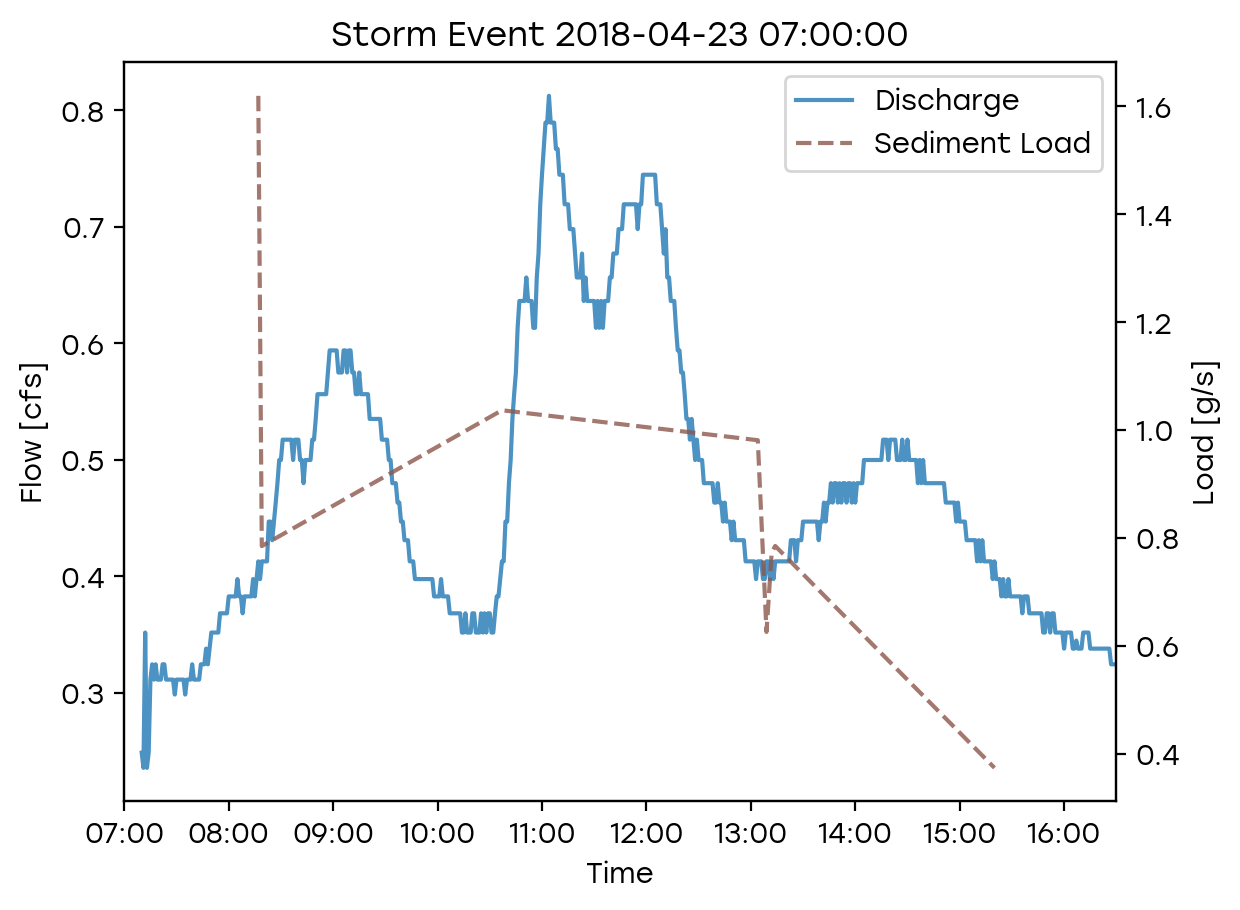

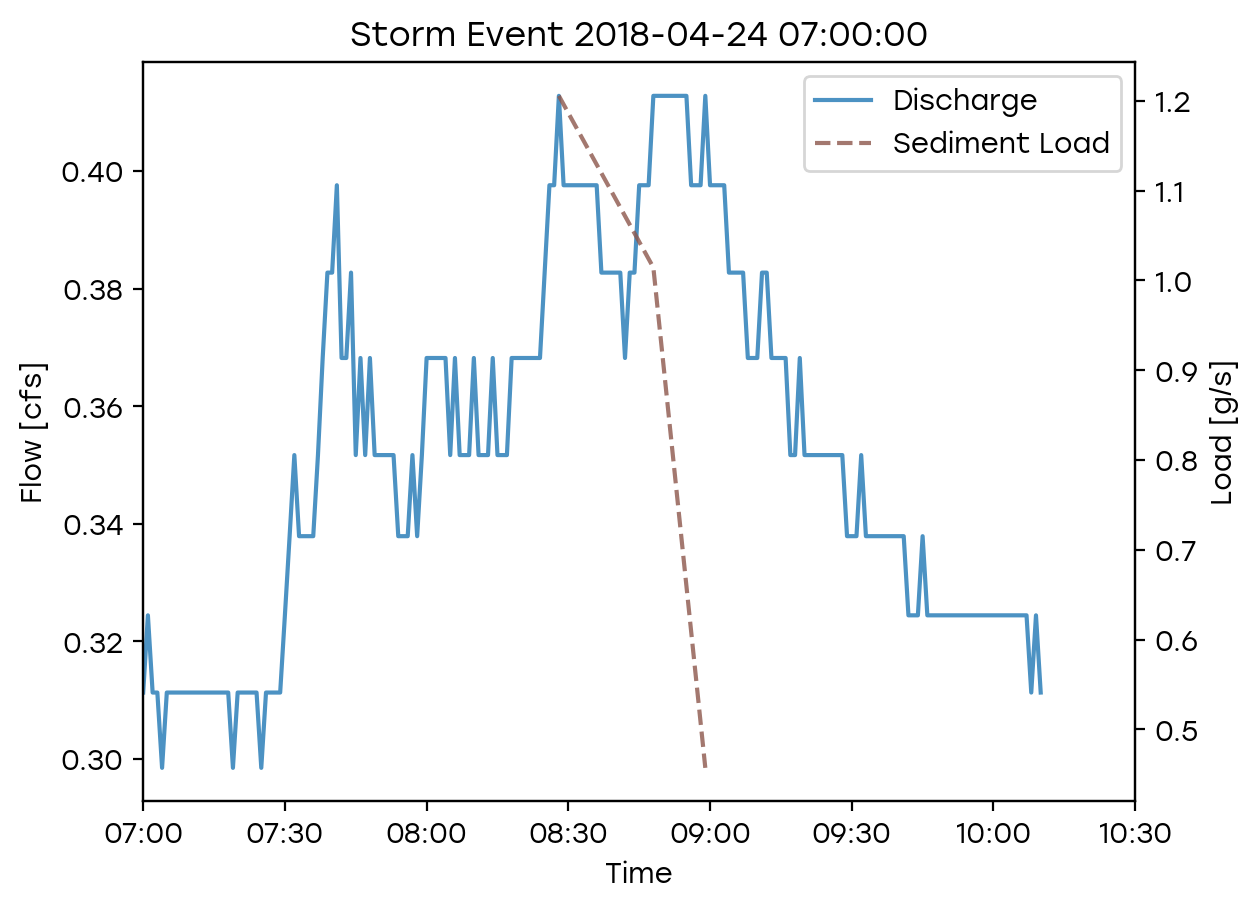

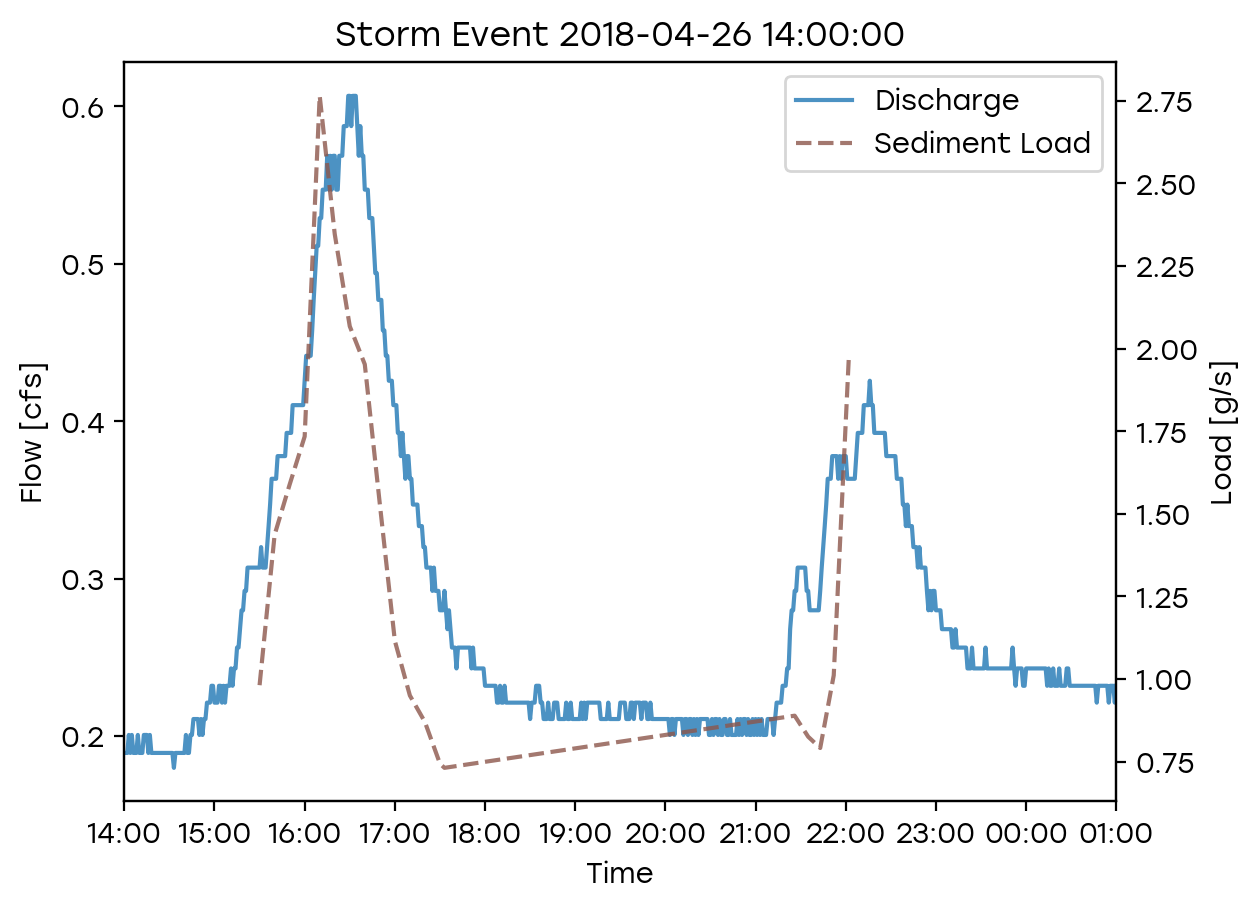

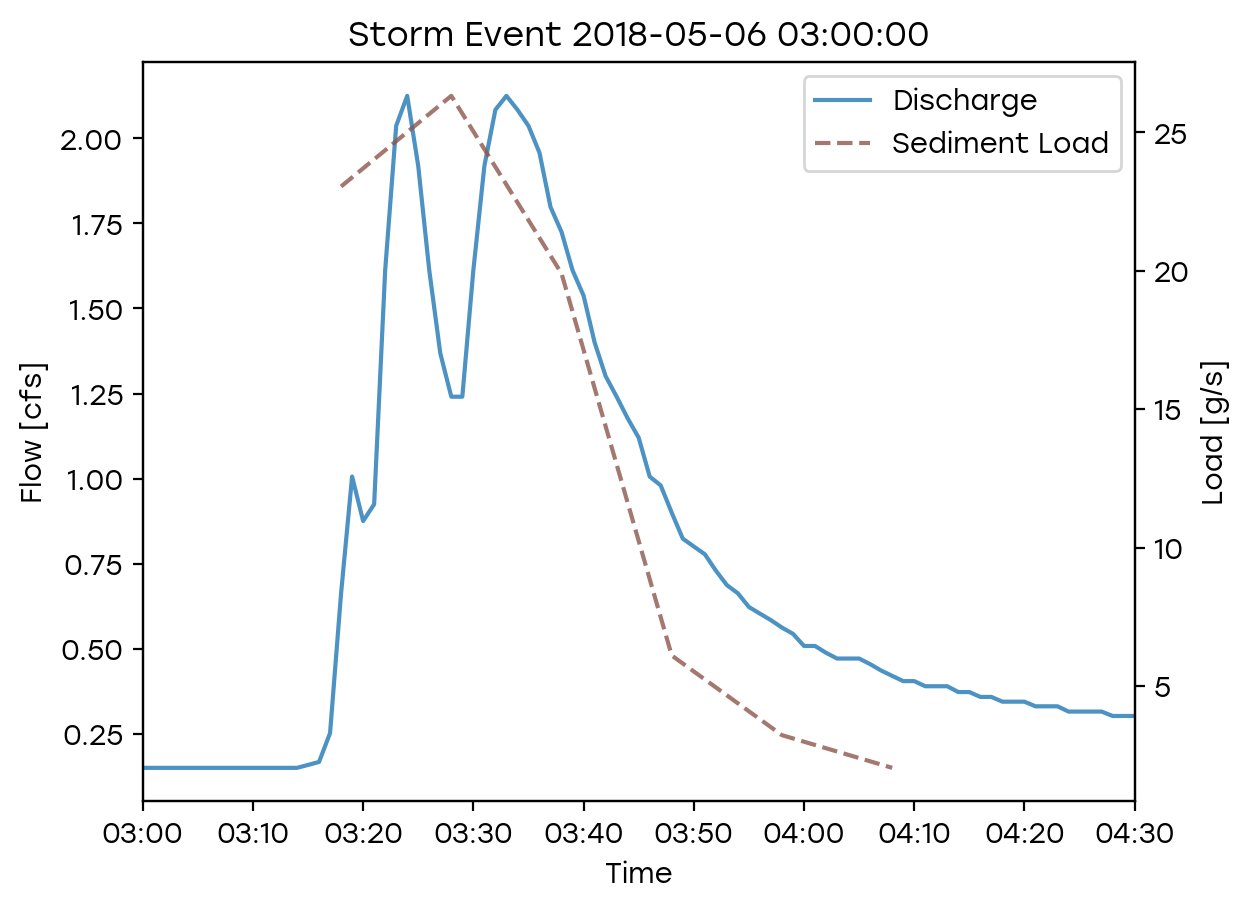

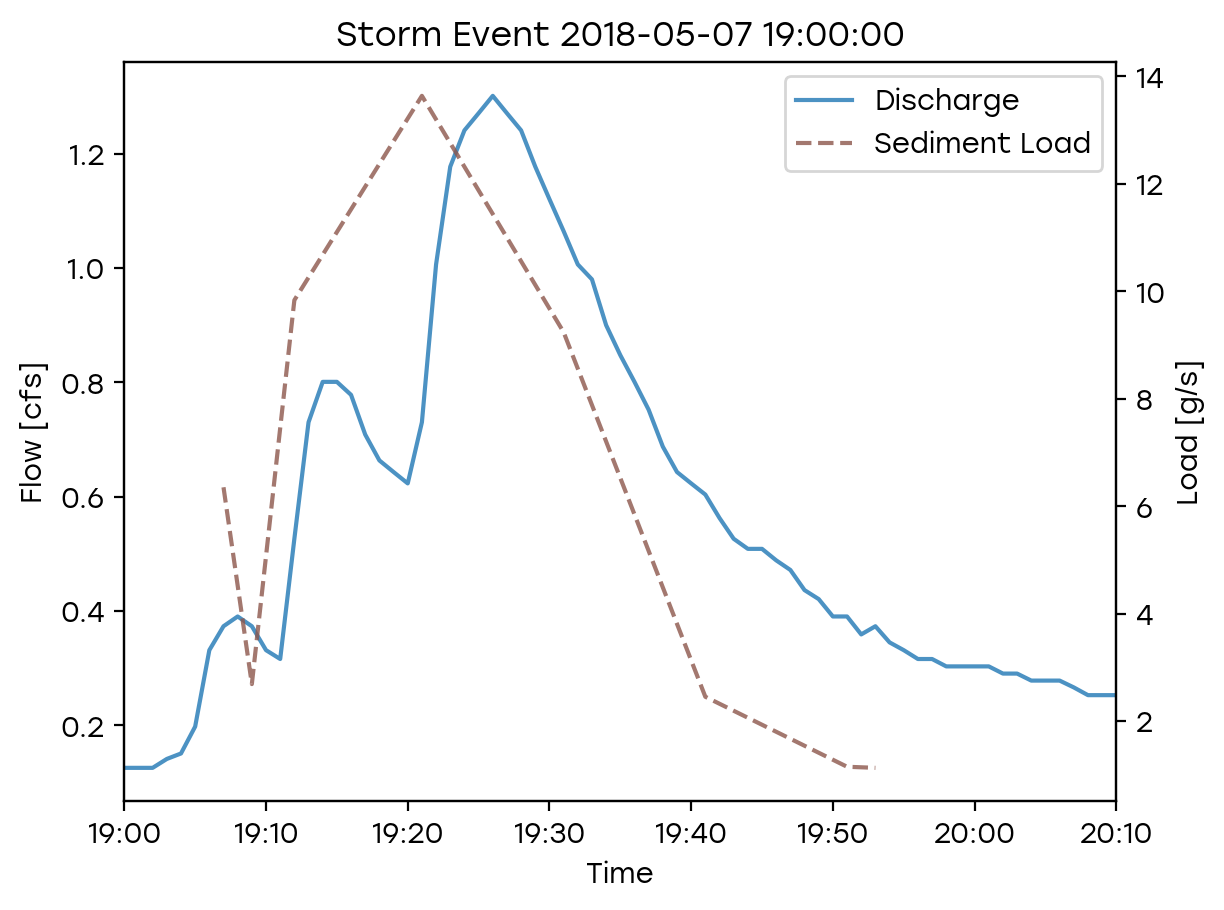

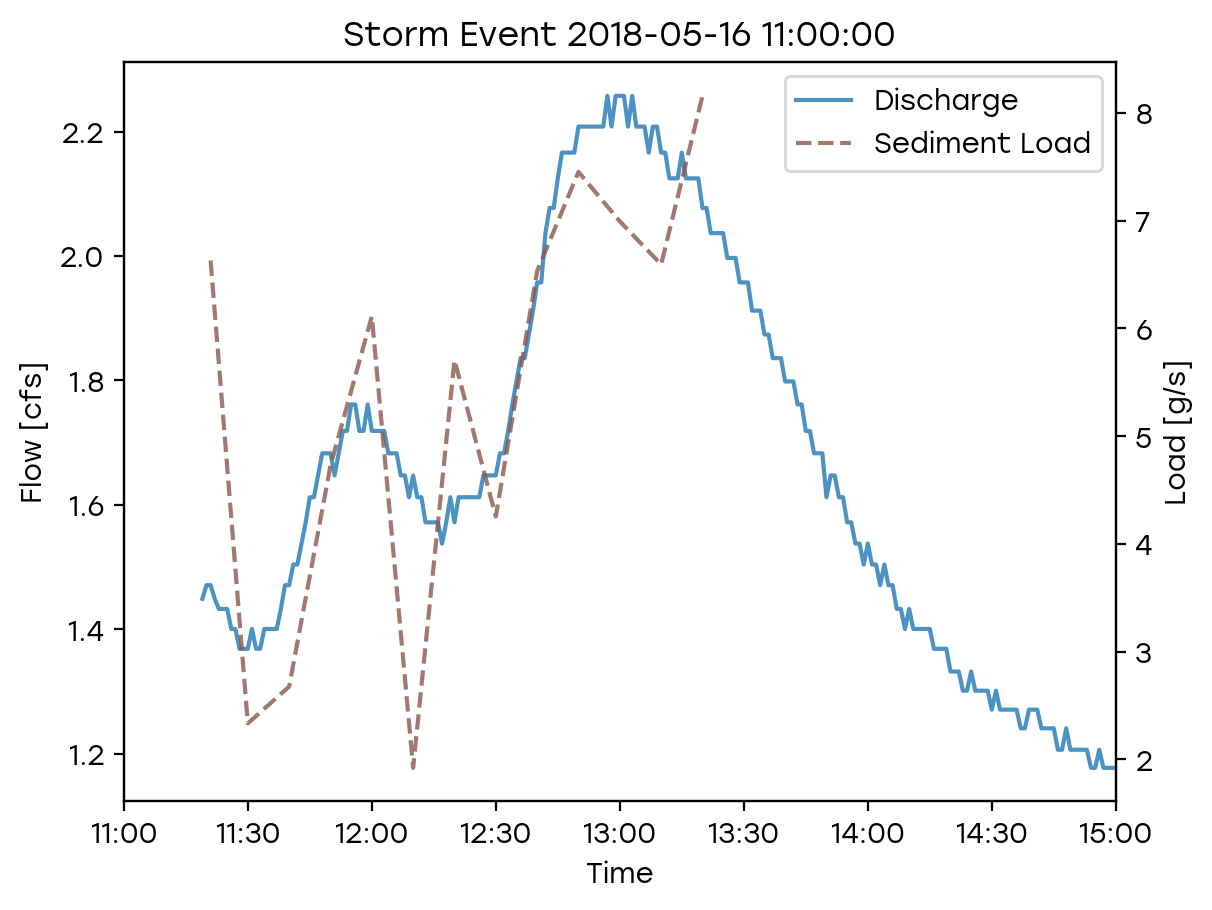

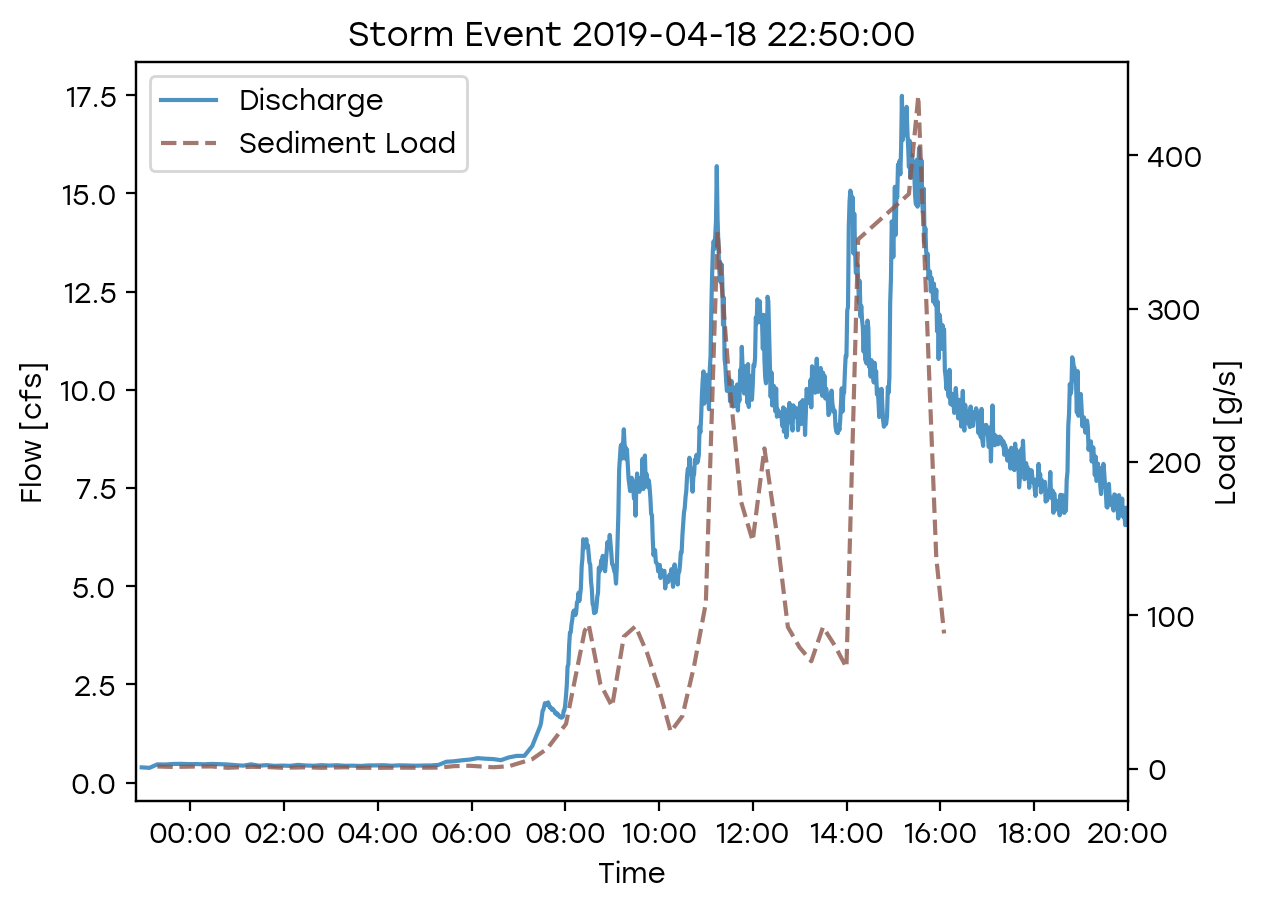

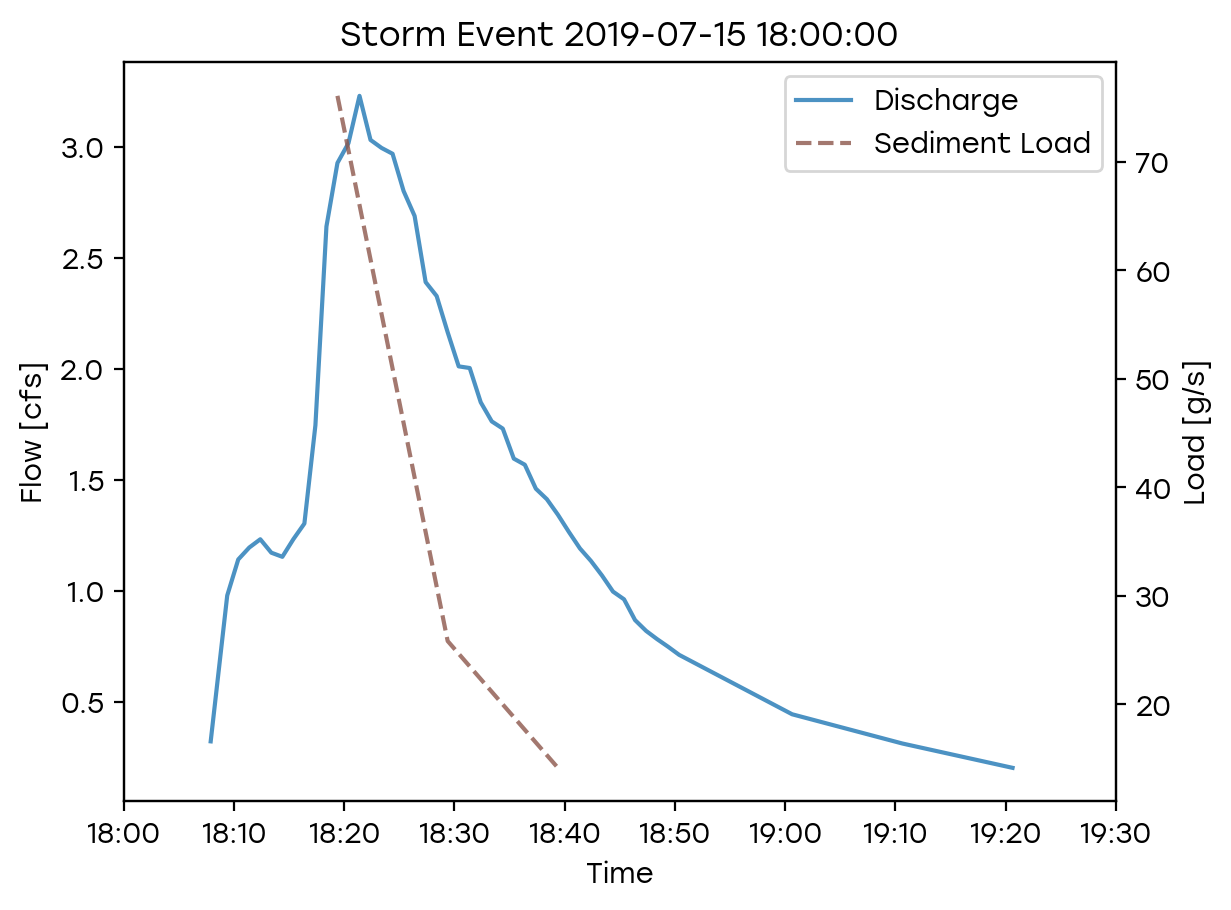

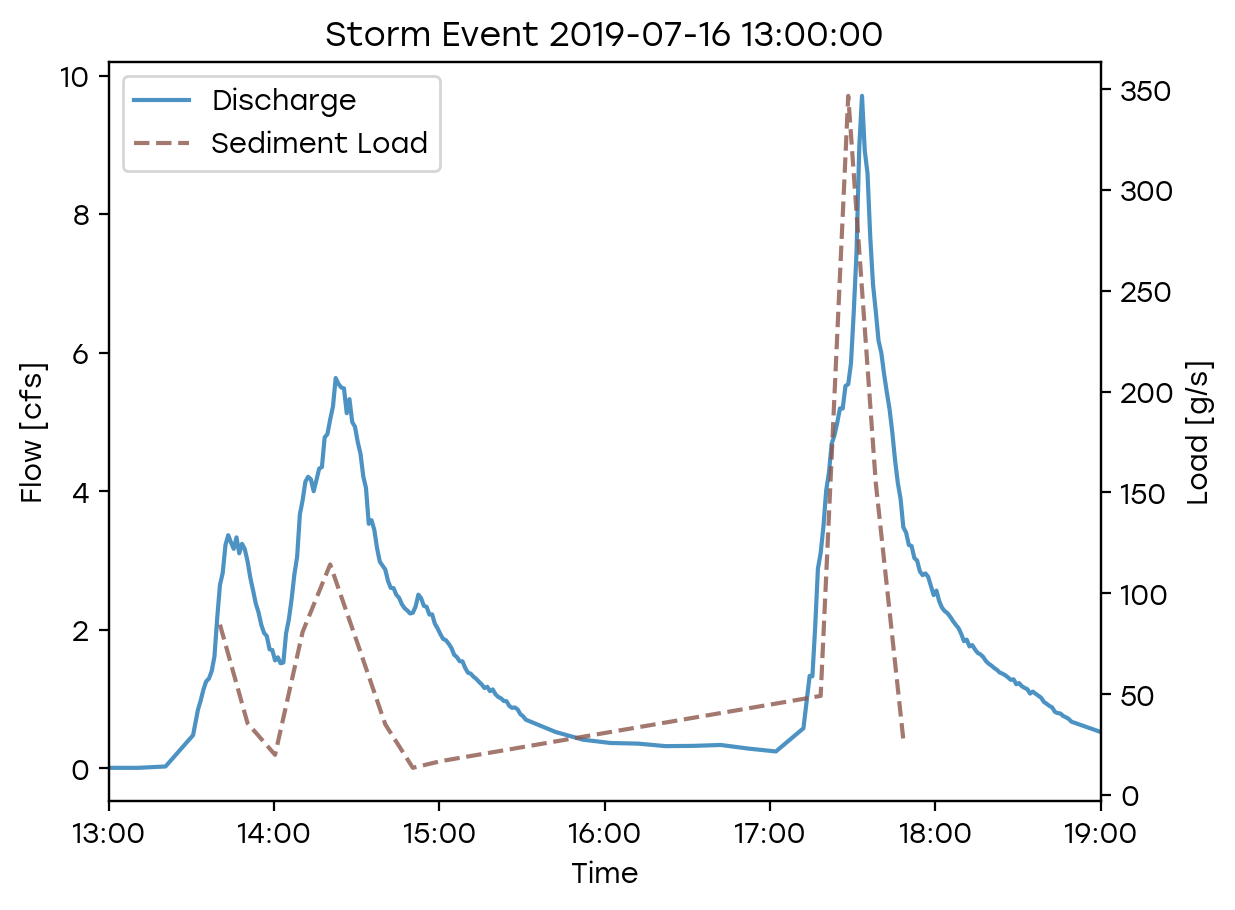

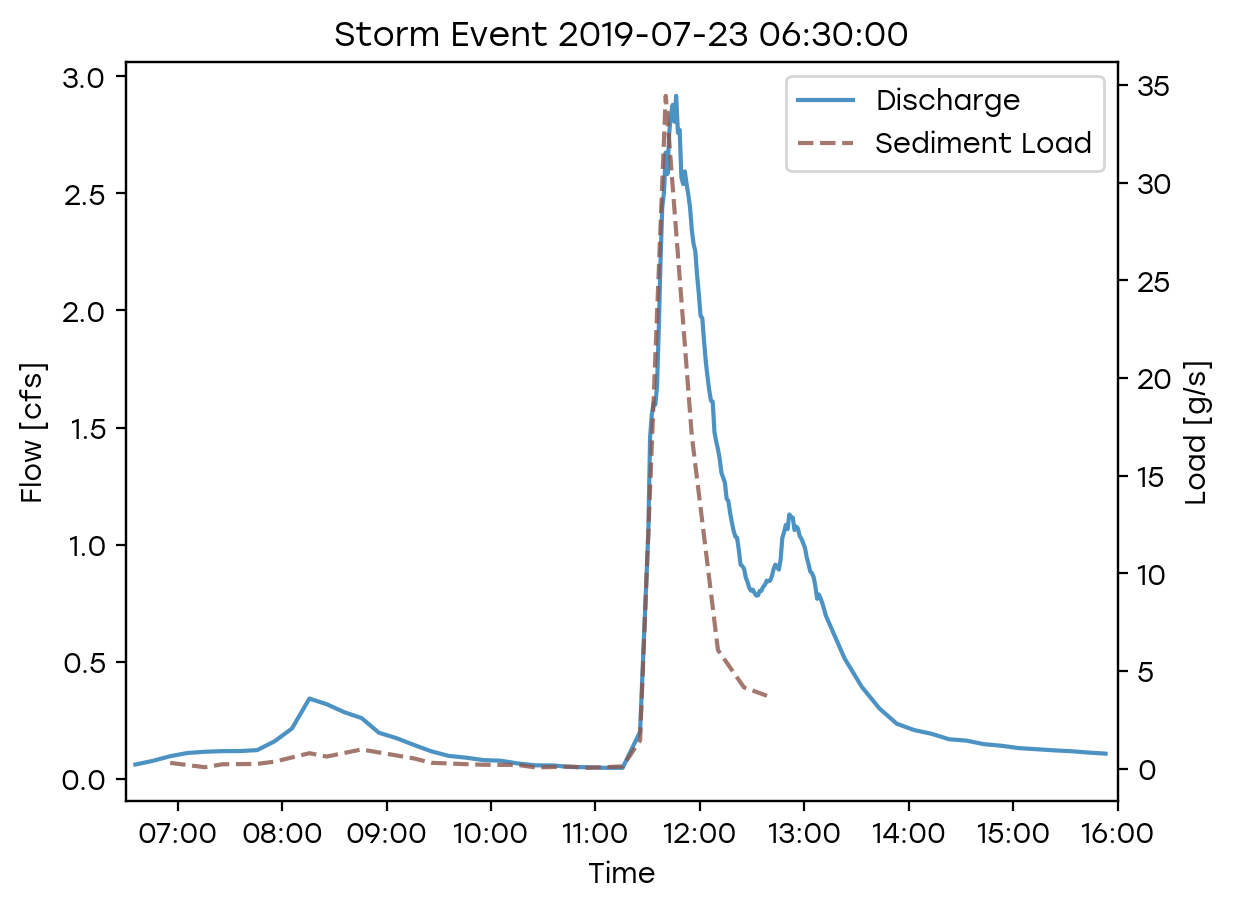

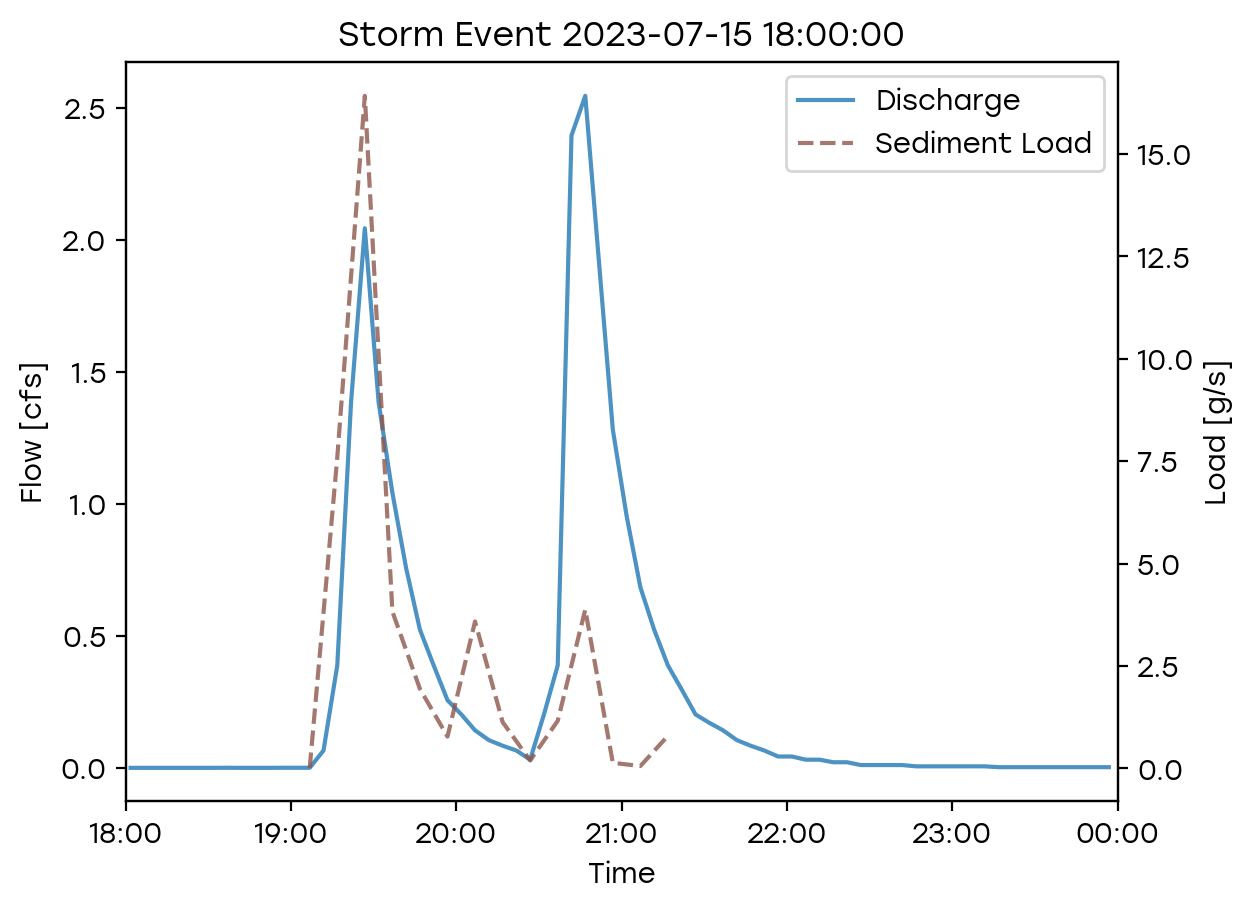

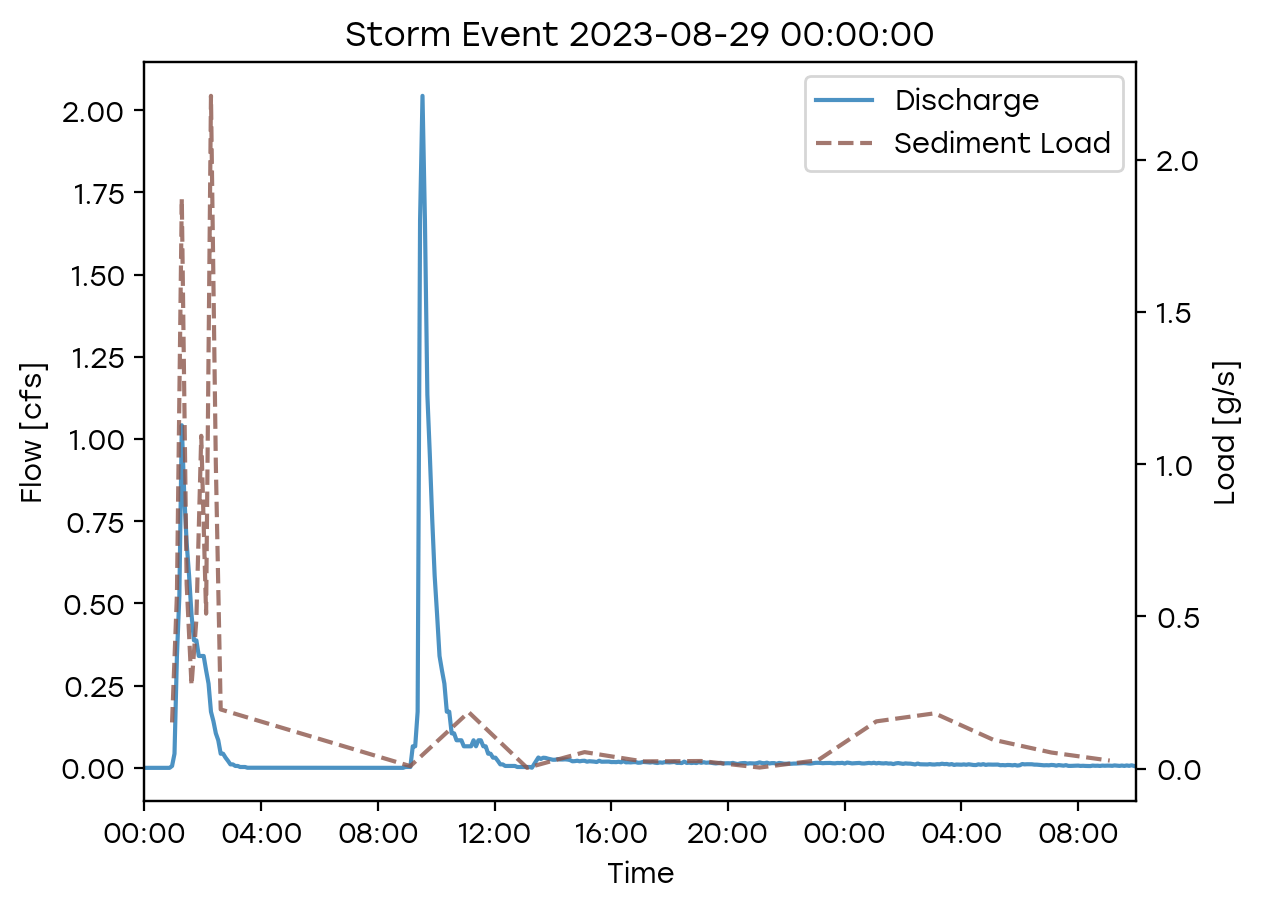

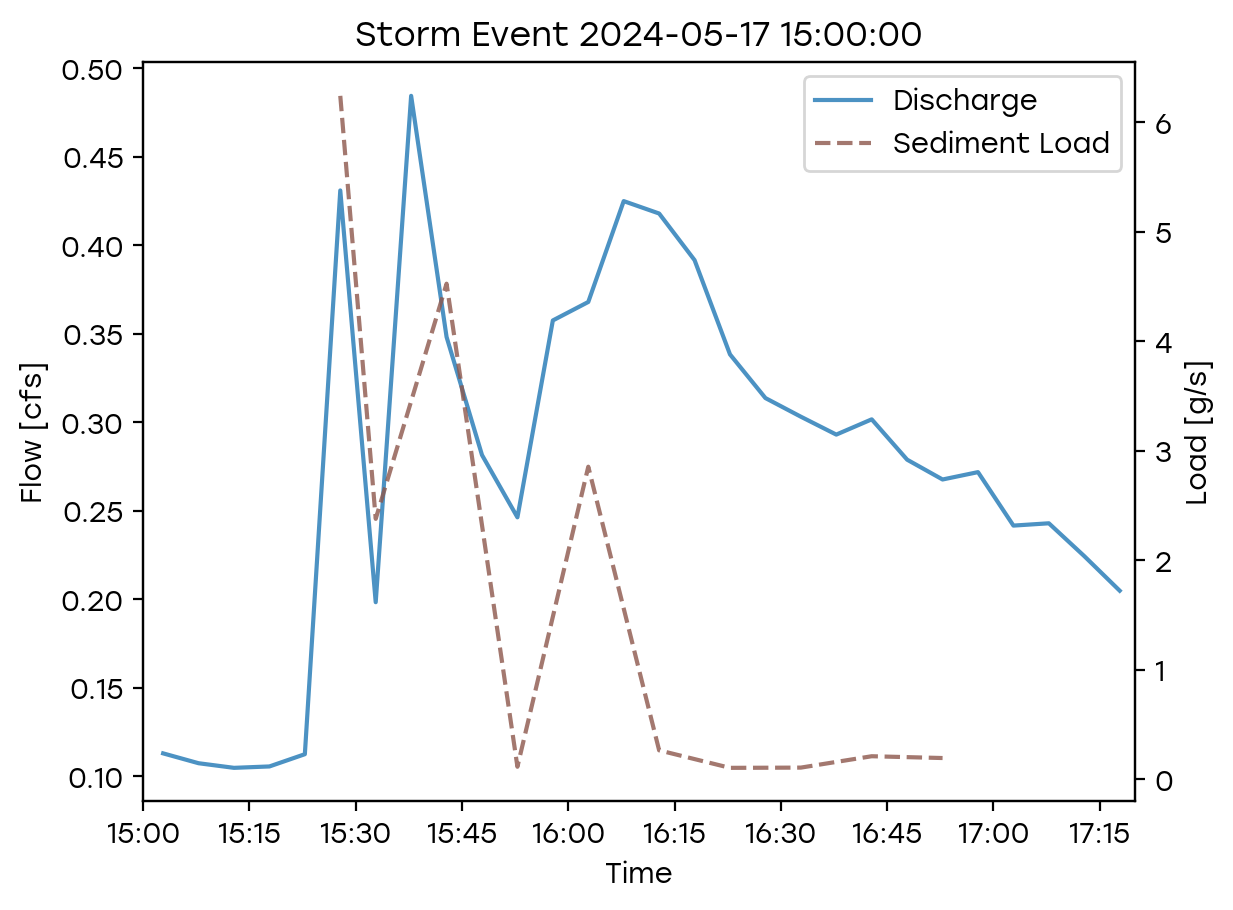

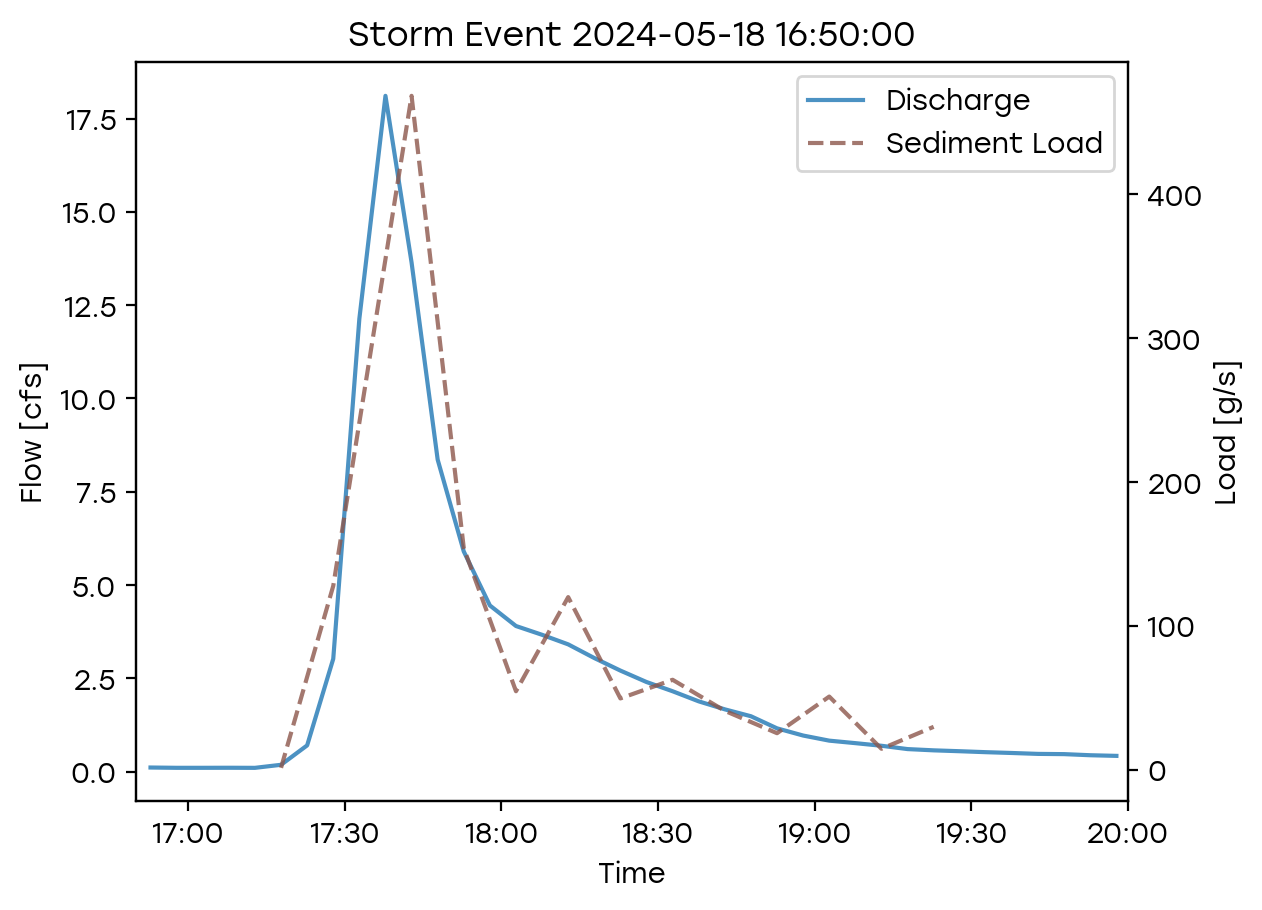

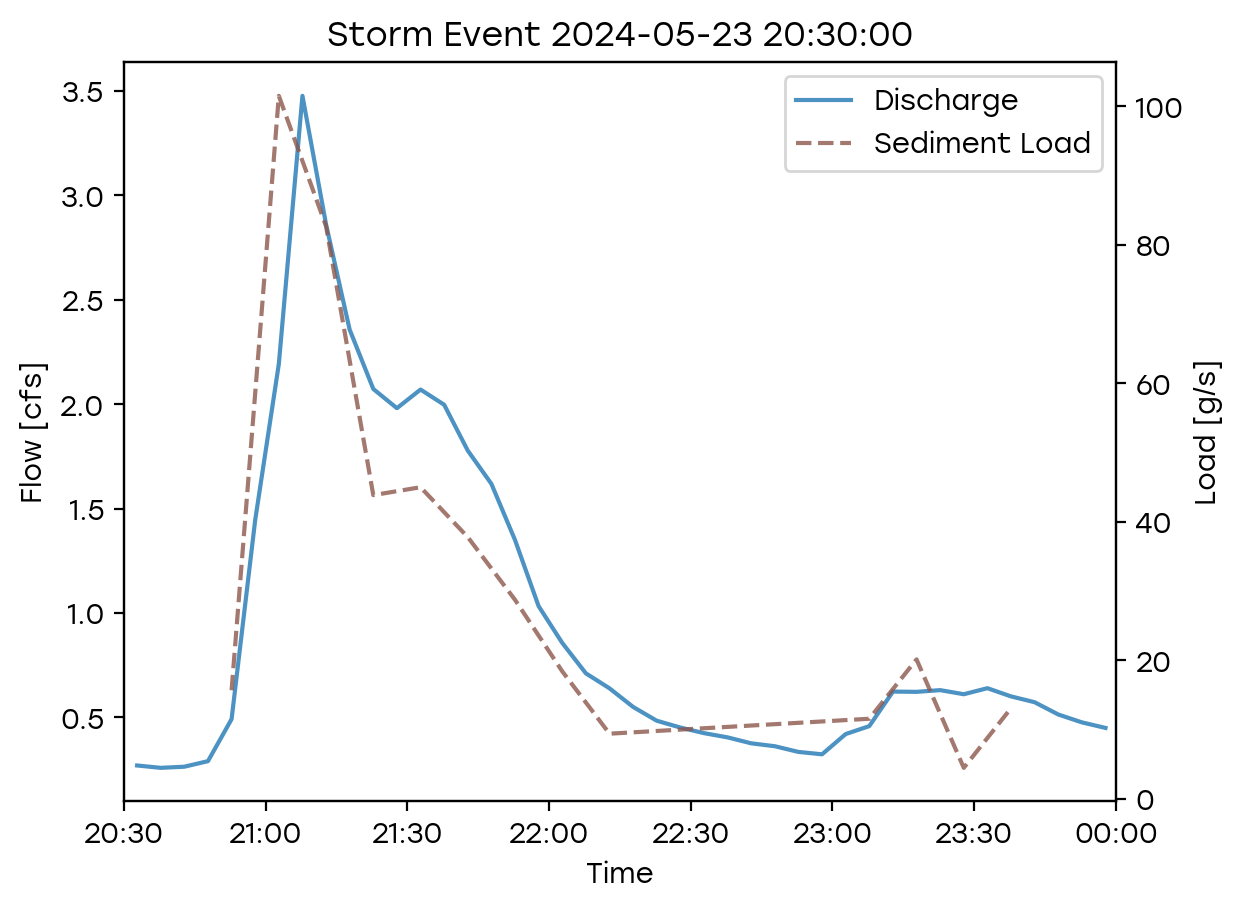

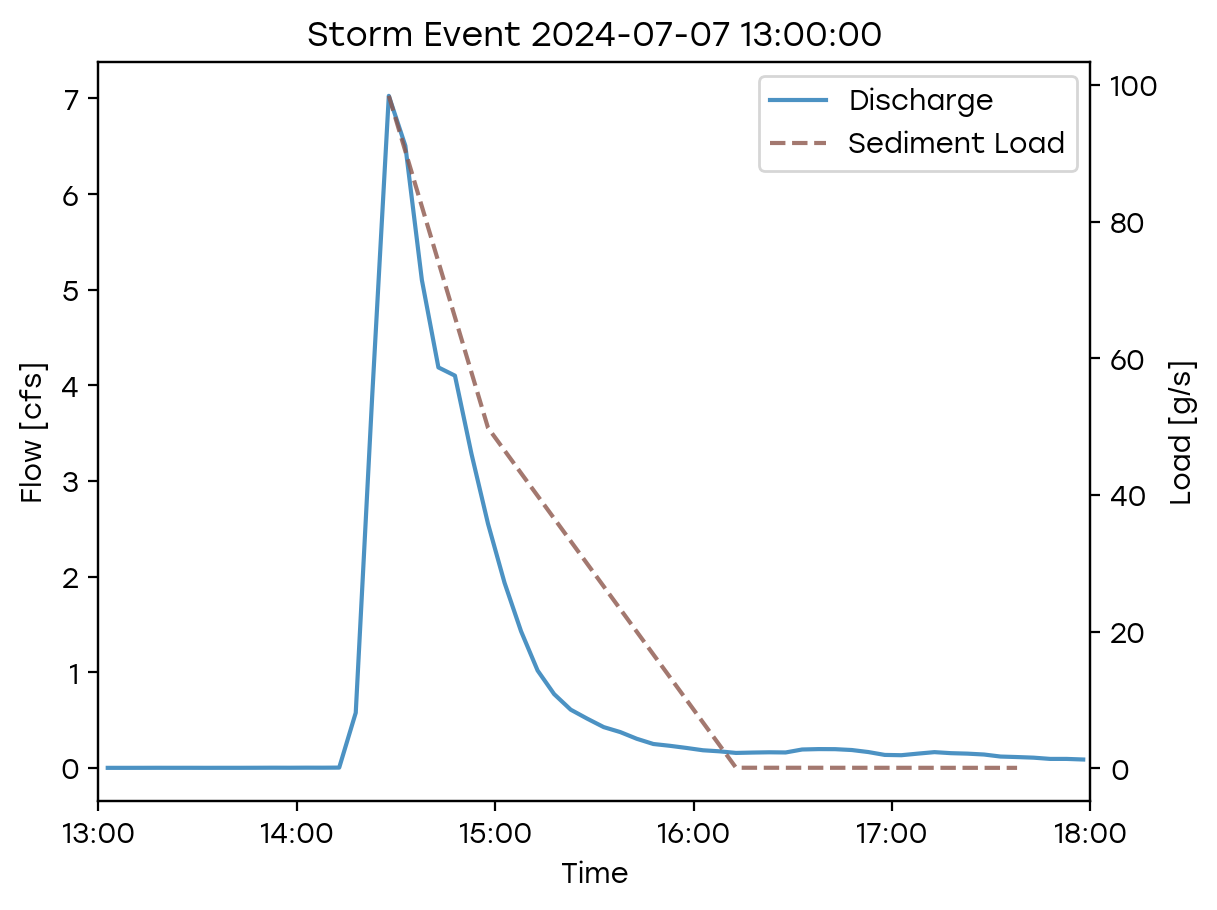

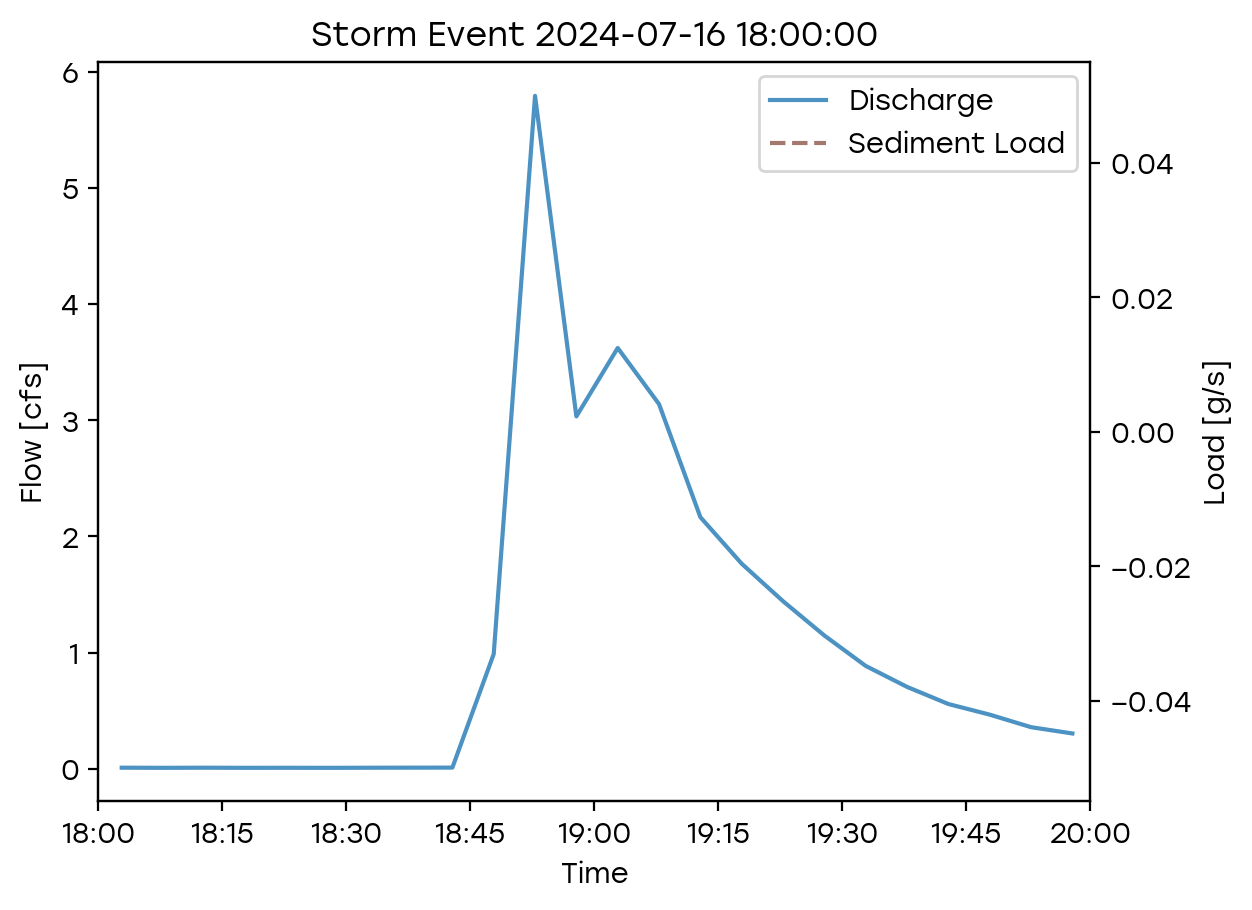

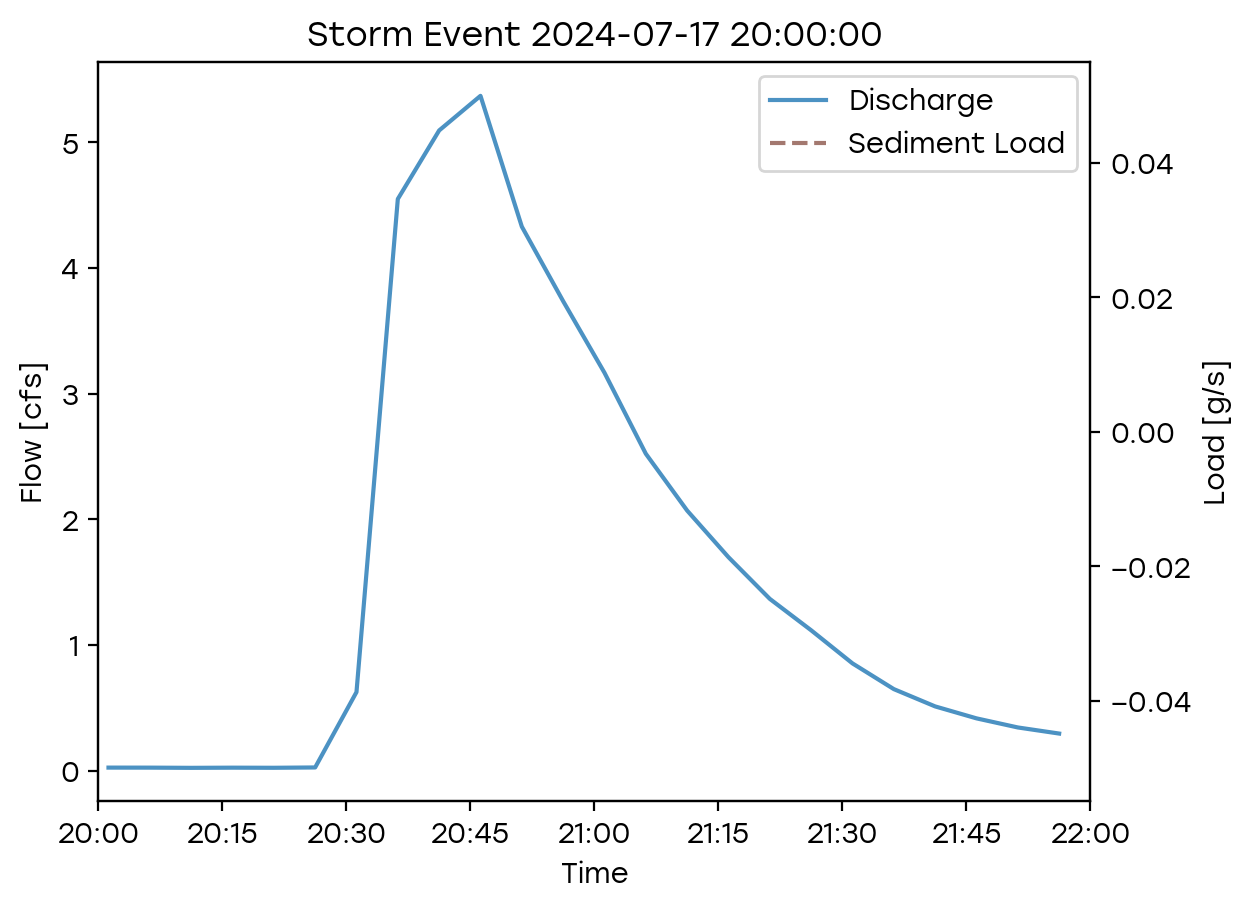

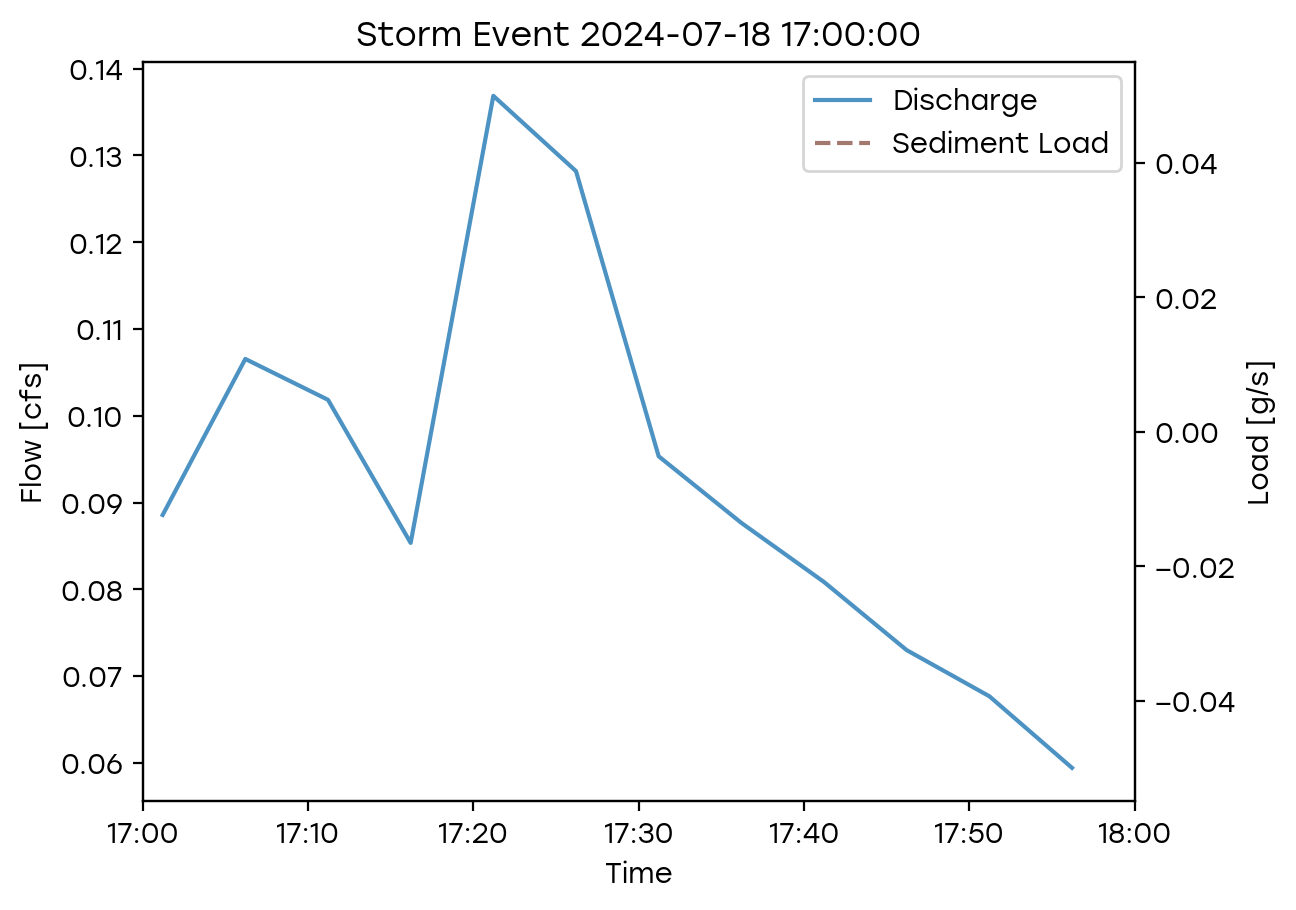

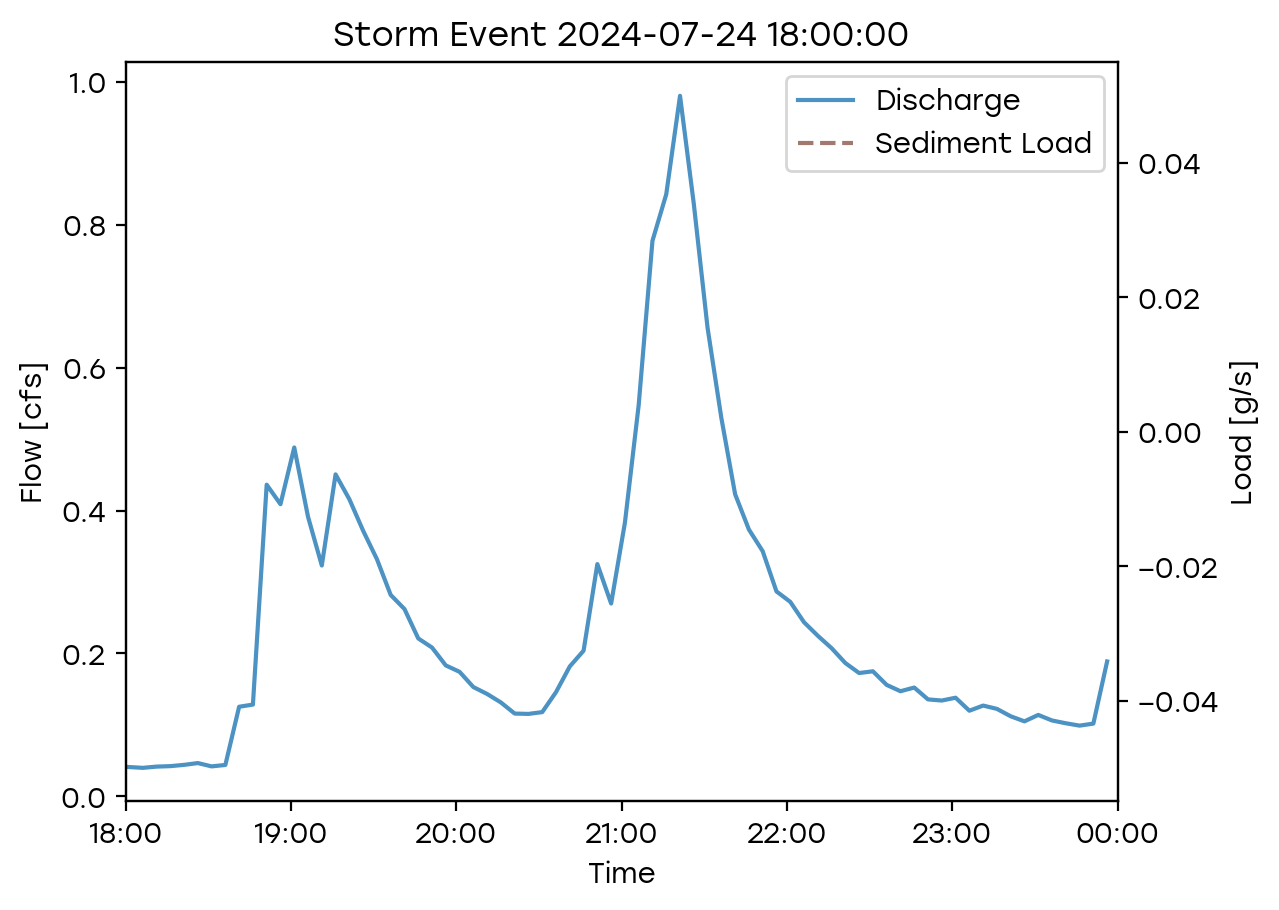

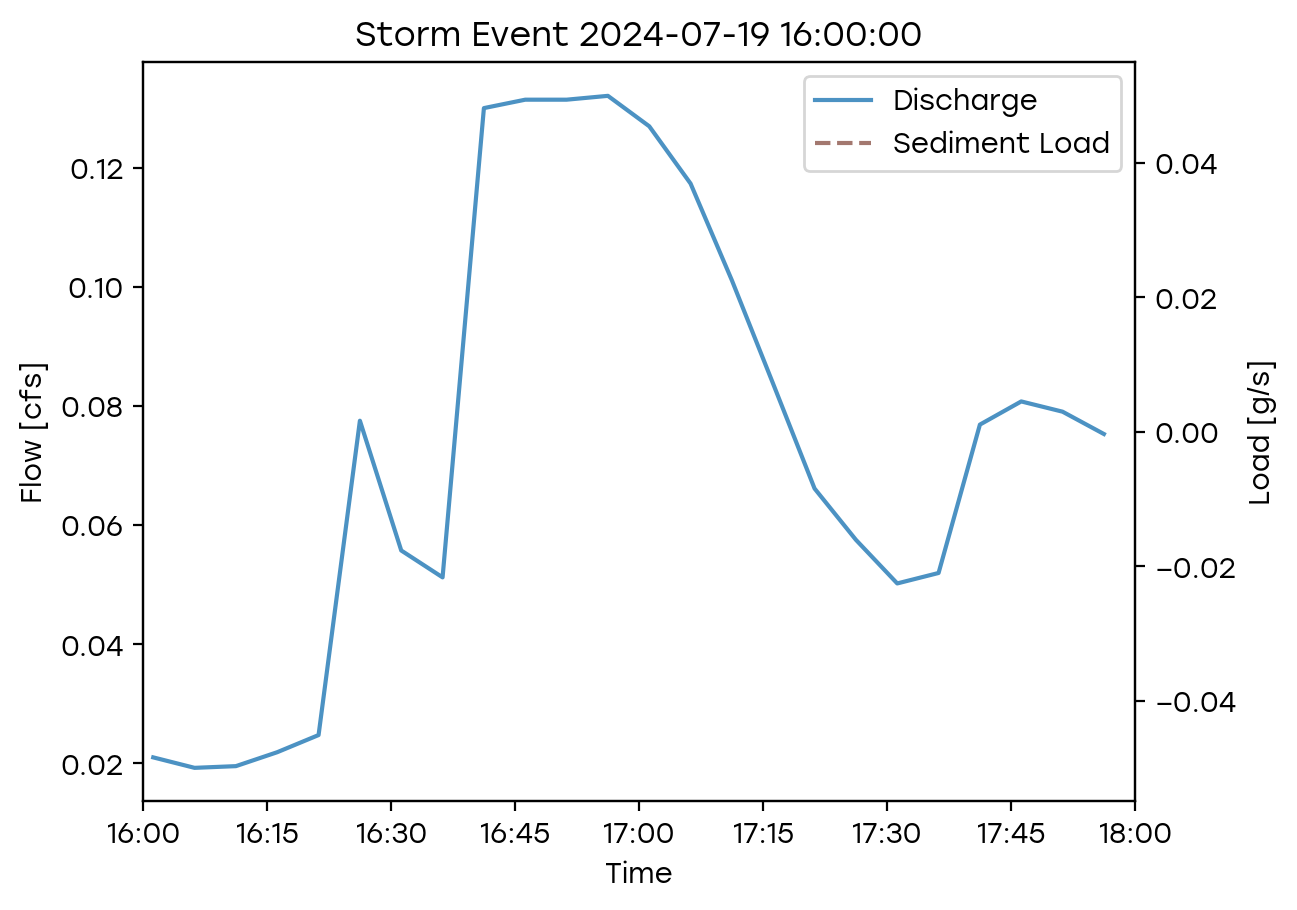

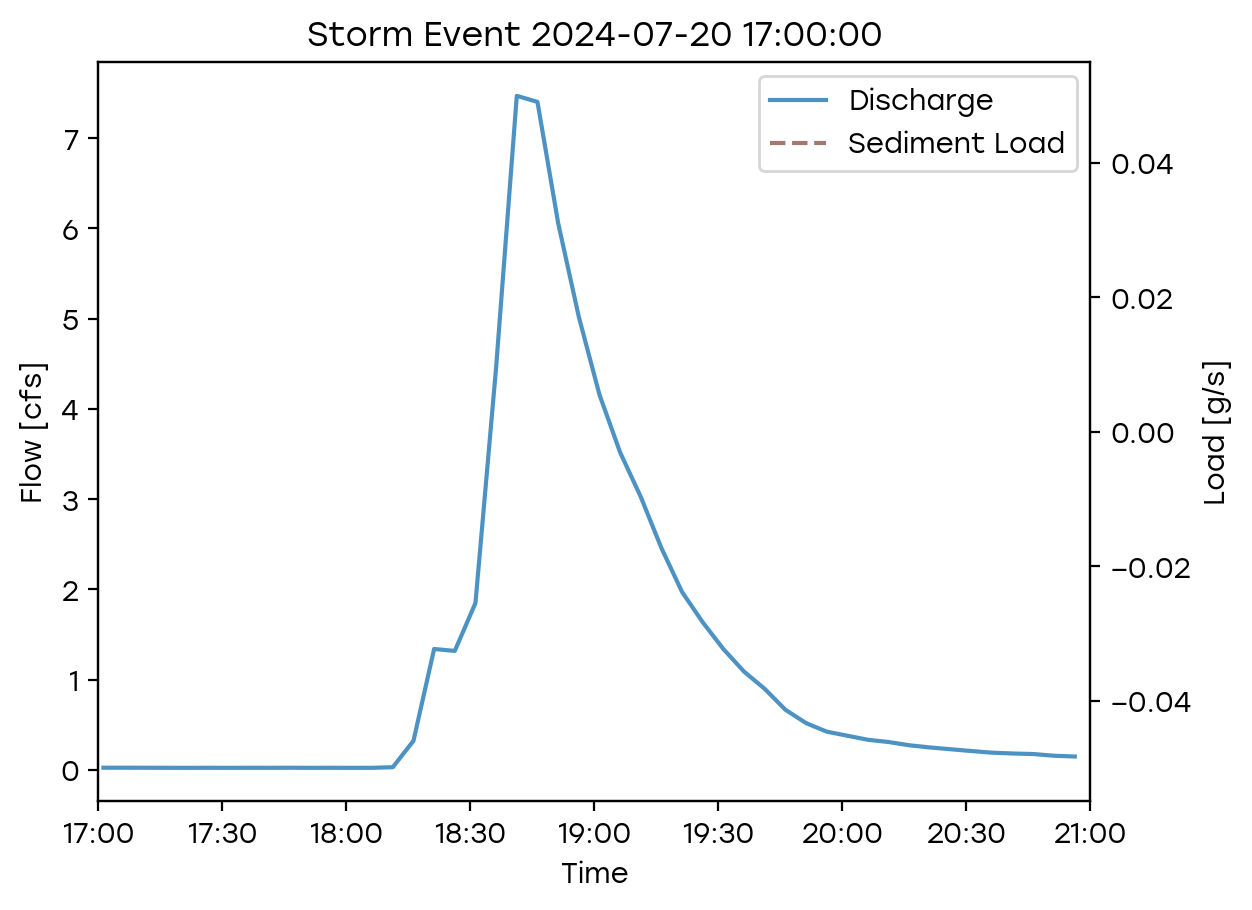

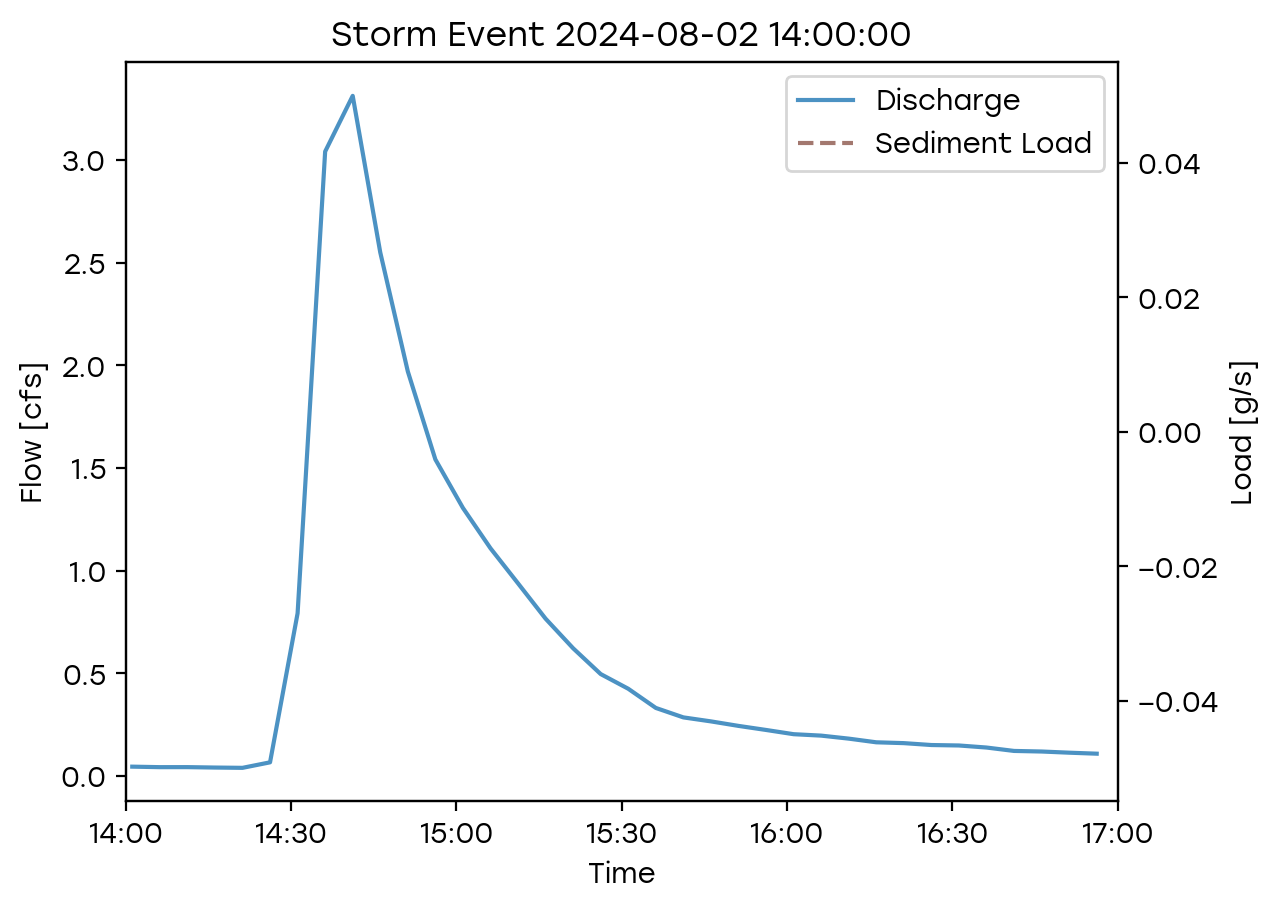

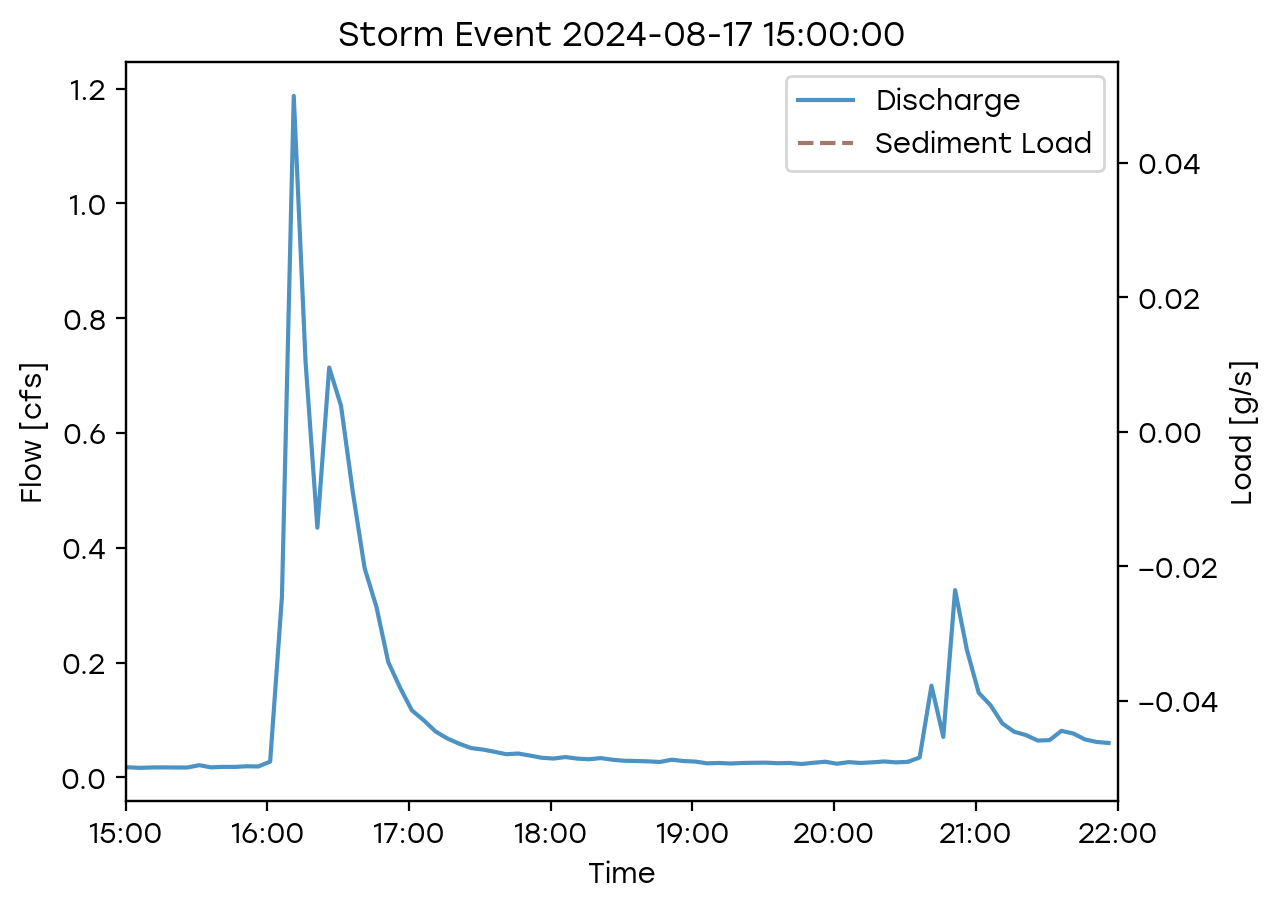

In [19]:
def plot_event(stage_sed_df, event_start, event_end):
    # filter master df to only be during event timespan
    event_df = stage_sed_df[(stage_sed_df['date_time_stage'] >= event_start) & (stage_sed_df['date_time_stage'] <= event_end)]
    # make sediment data continuous by dropping stage timestamps it didn't record for
    event_df_sed = event_df.dropna(subset=['conc_mg_L'])
    # display(event_df)
    # Q_trans = Q_Sam_frankenstein((P_rect-P_vnotch),P_rect,P_vnotch,B,angle_vnotch,units_str,b)


    # plot discharge vs. sed load time series
    fig1, ax1 = plt.subplots()

    # plot discharge vs. sed load with multiple weir equations
    # plot flow on first y-axis
    line1, = ax1.plot(event_df['date_time_stage'], event_df['Q_cfs_HollyFrank'], ls='-', color='tab:blue', alpha=0.8, label='Discharge')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow [cfs]') #, color='tab:blue')
    ax1.tick_params(axis='y') # , labelcolor='tab:blue')
    # Formatting the x-axis to show only the time
    ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # plot sediment load on second y-axis
    ax2 = ax1.twinx()
    line2, = ax2.plot(event_df_sed['date_time_stage'],event_df_sed['load_g_s_HollyFrank'], ls='--', color='tab:brown', alpha=0.8, label='Sediment Load')
    ax2.set_ylabel('Load [g/s]') #, color='tab:orange')
    ax2.tick_params(axis='y') # , labelcolor='tab:orange')
    # Formatting the x-axis to show only the time
    ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    # combine both axes legends into one
    # lines = [line1, line2, line3, line4, line5, line6]
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels)

    plt.xlim([event_start,event_end])
    plt.title('Storm Event {}'.format(event_start))
    plt.savefig('figures/Hydrograph_LoadDischarge_{}_autoscale.pdf'.format(i_event), bbox_inches='tight', pad_inches=0.05)
    plt.show()
    # plt.close()
    
    return fig1


for i_event in range(len(events_nested_pairs)):
    event = events_nested_pairs[i_event]
    event_start = pd.Timestamp(str(event[0]))
    event_end = pd.Timestamp(str(event[1]))

    plot_event(stage_sed_df, event_start, event_end)
    # fig = plot_event(stage_sed_df, event_start, event_end)
    # plt.show()
    # plt.close()

Pre-Construction:
slope =  1.6565770734905374
intercept =  0.7414428709497874
R^2 =  0.7683015342248299
Pre-Construction:
slope =  1.5770735441016017
intercept =  0.6327734831970302
R^2 =  0.9341065792429367
Pre-Construction:
slope =  1.5937352027851106
intercept =  0.8932845703029274
R^2 =  0.5701066113624206


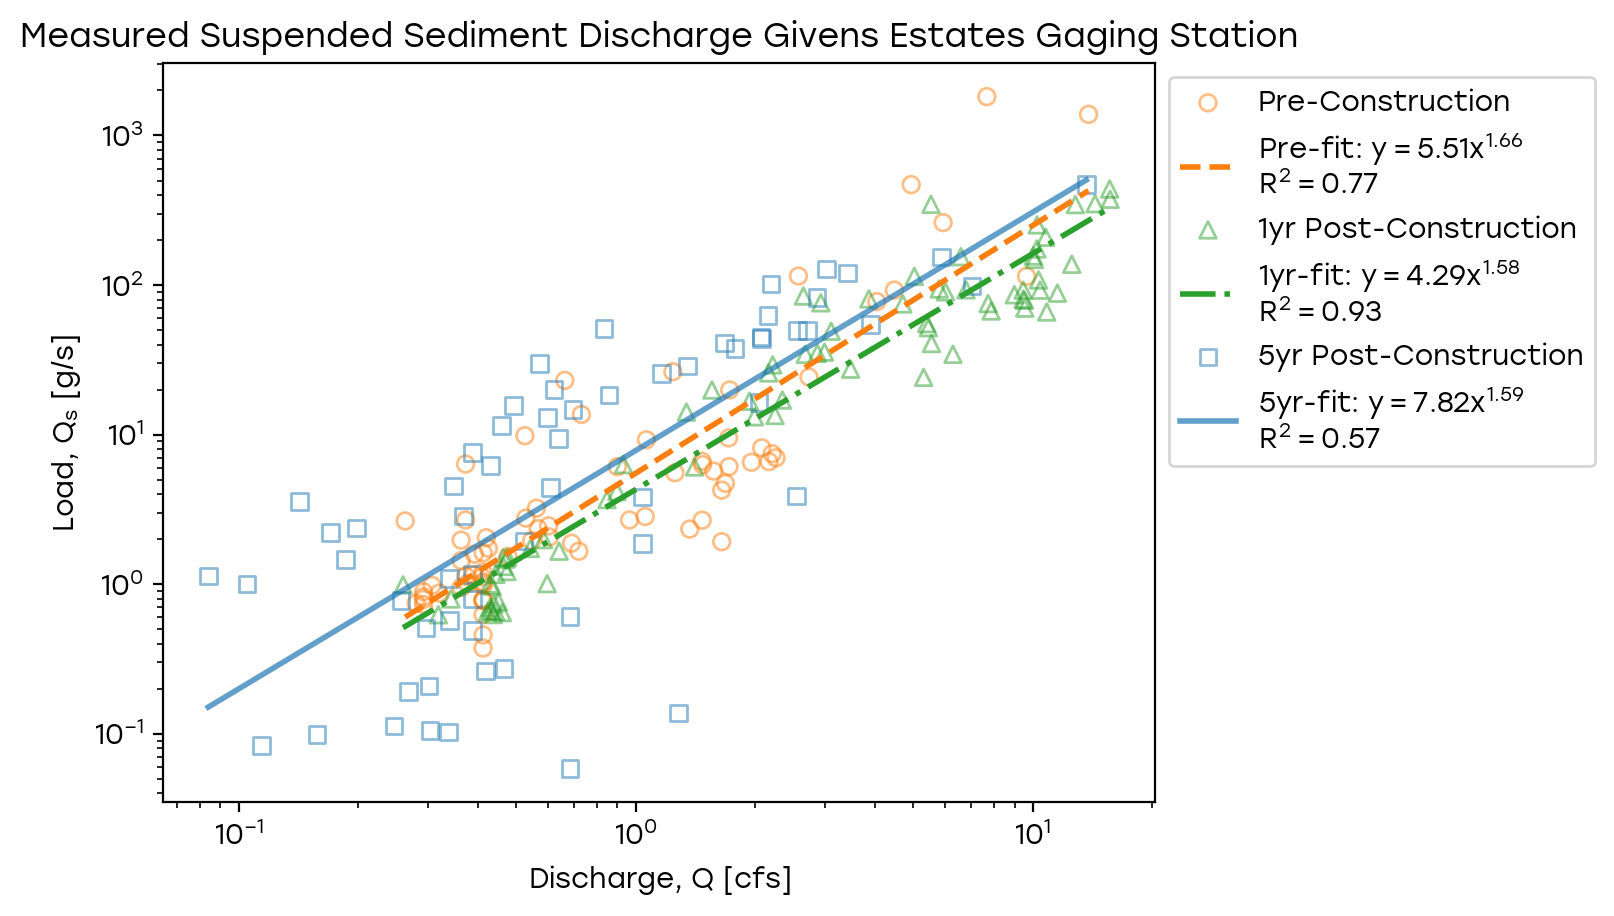

In [30]:
# create sediment rating curves (e.g., log-log plot of Load [g/s] vs. Q [cfs] with line of best fit and R^2])
# create dataframe for plot - only where ISCO was sampled
rating_curve_df = stage_sed_df.copy()
rating_curve_df = rating_curve_df.dropna(subset=['conc_mg_L'])
rating_curve_df = rating_curve_df[rating_curve_df['stage_corrected_ft'] > 0.2] # take out measurements below recommended minimum depth for v-notch weir

# tests
# rating_curve_df = rating_curve_df[rating_curve_df['Q_cfs_HollyFrank'] > 0.15]
# rating_curve_df = rating_curve_df[(rating_curve_df['date_time_stage'] < np.datetime64('2024-05-18')) | (rating_curve_df['date_time_stage'] >= np.datetime64('2024-05-19'))]
# rating_curve_df = rating_curve_df[(rating_curve_df['date_time_stage'] < np.datetime64('2024-05-23')) | (rating_curve_df['date_time_stage'] >= np.datetime64('2024-05-24'))]

# filter out data excluded in 2019 study
excluded_postExcel = [
    '2019-07-23 11:15',
    '2019-07-23 10:55',
    '2019-07-23 10:45',
    '2019-07-23 10:25',
    '2019-07-23 10:15',
    '2019-07-23 09:55',
    '2019-07-23 09:45',
    '2019-07-23 06:55',
    '2019-07-23 07:15',
    '2019-07-23 09:25',
    '2019-07-23 07:25',
    '2019-07-23 07:45',
    '2019-07-23 09:15',
    '2019-07-23 07:55',
    '2019-07-23 08:55',
    '2019-07-23 11:25',
]
rating_curve_df['timestamp_no_seconds'] = rating_curve_df['date_time_isco'].dt.strftime('%Y-%m-%d %H:%M')
rating_curve_df = rating_curve_df[~rating_curve_df['timestamp_no_seconds'].isin(excluded_postExcel)]
rating_curve_df = rating_curve_df.drop(columns=['timestamp_no_seconds'])

# split dataframes in to pre vs. post timeframes
pre_rating_df = rating_curve_df[rating_curve_df['date_time_stage'] < np.datetime64('2019-01-01')]
post_1yr_rating_df = rating_curve_df[(rating_curve_df['date_time_stage'] >= np.datetime64('2019-01-01')) & (rating_curve_df['date_time_stage'] < np.datetime64('2020-01-01'))]
post_5yr_rating_df = rating_curve_df[rating_curve_df['date_time_stage'] > np.datetime64('2023-01-01')]

# Q_pre = pre_rating_df['Q_cfs_HollyFrank']
# load_pre = pre_rating_df['load_g_s_HollyFrank']
# Q_1yr = post_1yr_rating_df['Q_cfs_HollyFrank']
# load_1yr = post_1yr_rating_df['load_g_s_HollyFrank']
# Q_5yr = post_5yr_rating_df['Q_cfs_HollyFrank']
# load_5yr = post_5yr_rating_df['load_g_s_HollyFrank']

# Q_pre = pre_rating_df['Q_cfs_SamFrank']
# load_pre = pre_rating_df['load_g_s_SamFrank']
# Q_1yr = post_1yr_rating_df['Q_cfs_SamFrank']
# load_1yr = post_1yr_rating_df['load_g_s_SamFrank']
# Q_5yr = post_5yr_rating_df['Q_cfs_SamFrank']
# load_5yr = post_5yr_rating_df['load_g_s_SamFrank']

# Q_pre = pre_rating_df['Q_cfs_PhilFrank']
# load_pre = pre_rating_df['load_g_s_PhilFrank']
# Q_1yr = post_1yr_rating_df['Q_cfs_PhilFrank']
# load_1yr = post_1yr_rating_df['load_g_s_PhilFrank']
# Q_5yr = post_5yr_rating_df['Q_cfs_PhilFrank']
# load_5yr = post_5yr_rating_df['load_g_s_PhilFrank']

# pre
x = np.array(pre_rating_df['Q_cfs_HollyFrank']).reshape(-1,1)
y = np.array(pre_rating_df['load_g_s_HollyFrank'])
log_x = np.log10(x)
log_y = np.log10(y)
model = LinearRegression().fit(log_x, log_y) # fit_intercept=False
x_plot = np.linspace(min(x), max(x), 100)
y_plot = 10**model.predict(np.log10(x_plot))
log_y_pred = model.predict(log_x)
r_sq = r2_score(log_y, log_y_pred)
print('Pre-Construction:')
print('slope = ', model.coef_[0])
print('intercept = ', model.intercept_)
print('R^2 = ', r_sq)

plt.scatter(x, y, label='Pre-Construction', alpha=0.5, marker='o', facecolors='none', edgecolors='tab:orange')
plt.plot(x_plot, y_plot, ls='--', lw='2', color='tab:orange', label='Pre-fit: $y = {:.2f}x^{{{:.2f}}}$\n$R^2 = {:.2f}$'.format(10**model.intercept_, model.coef_[0], r_sq))

# post 1yr
x = np.array(post_1yr_rating_df['Q_cfs_HollyFrank']).reshape(-1,1)
y = np.array(post_1yr_rating_df['load_g_s_HollyFrank'])
log_x = np.log10(x)
log_y = np.log10(y)
model = LinearRegression().fit(log_x, log_y) # fit_intercept=False
x_plot = np.linspace(min(x), max(x), 100)
y_plot = 10**model.predict(np.log10(x_plot))
log_y_pred = model.predict(log_x)
r_sq = r2_score(log_y, log_y_pred)
print('Pre-Construction:')
print('slope = ', model.coef_[0])
print('intercept = ', model.intercept_)
print('R^2 = ', r_sq)

plt.scatter(x, y, label='1yr Post-Construction', alpha=0.5, marker='^', facecolors='none', edgecolors='tab:green')
plt.plot(x_plot, y_plot, ls='-.', lw='2', color='tab:green', label='1yr-fit: $y = {:.2f}x^{{{:.2f}}}$\n$R^2 = {:.2f}$'.format(10**model.intercept_, model.coef_[0], r_sq))

# post 5yr
x = np.array(post_5yr_rating_df['Q_cfs_HollyFrank']).reshape(-1,1)
y = np.array(post_5yr_rating_df['load_g_s_HollyFrank'])
log_x = np.log10(x)
log_y = np.log10(y)
model = LinearRegression().fit(log_x, log_y) # fit_intercept=False
x_plot = np.linspace(min(x), max(x), 100)
y_plot = 10**model.predict(np.log10(x_plot))
log_y_pred = model.predict(log_x)
r_sq = r2_score(log_y, log_y_pred)
print('Pre-Construction:')
print('slope = ', model.coef_[0])
print('intercept = ', model.intercept_)
print('R^2 = ', r_sq)

plt.scatter(x, y, label='5yr Post-Construction', alpha=0.5, marker='s', facecolors='none', edgecolors='tab:blue')
# quick check
post_4yr_rating_df = rating_curve_df[(rating_curve_df['date_time_stage'] > np.datetime64('2023-01-01')) & (rating_curve_df['date_time_stage'] < np.datetime64('2024-01-01'))]
Q_4yr = post_4yr_rating_df['Q_cfs_HollyFrank']
load_4yr = post_4yr_rating_df['load_g_s_HollyFrank']
x_test = np.array(Q_4yr).reshape(-1,1)
y_test = np.array(load_4yr)
# plt.scatter(x_test, y_test, label='2023', alpha=0.5, marker='*', facecolors='none', edgecolors='red')
plt.plot(x_plot, y_plot, alpha=0.7, ls='-', lw='2', color='tab:blue', label='5yr-fit: $y = {:.2f}x^{{{:.2f}}}$\n$R^2 = {:.2f}$'.format(10**model.intercept_, model.coef_[0], r_sq))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Discharge, $Q$ [cfs]')
plt.ylabel('Load, $Q_s$ [g/s]')
plt.title('Measured Suspended Sediment Discharge Givens Estates Gaging Station')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.savefig('figures/RatingCurve_All3.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()


Pre-Construction:
slope =  1.9140675295331802
intercept =  0.6400564326013594
R^2 =  0.6926768516458822
Pre-Construction:
slope =  1.3925617061173299
intercept =  0.7811959583322563
R^2 =  0.8356017035266291
Pre-Construction:
slope =  1.5088432716634064
intercept =  0.969181457665587
R^2 =  0.37503639014624823


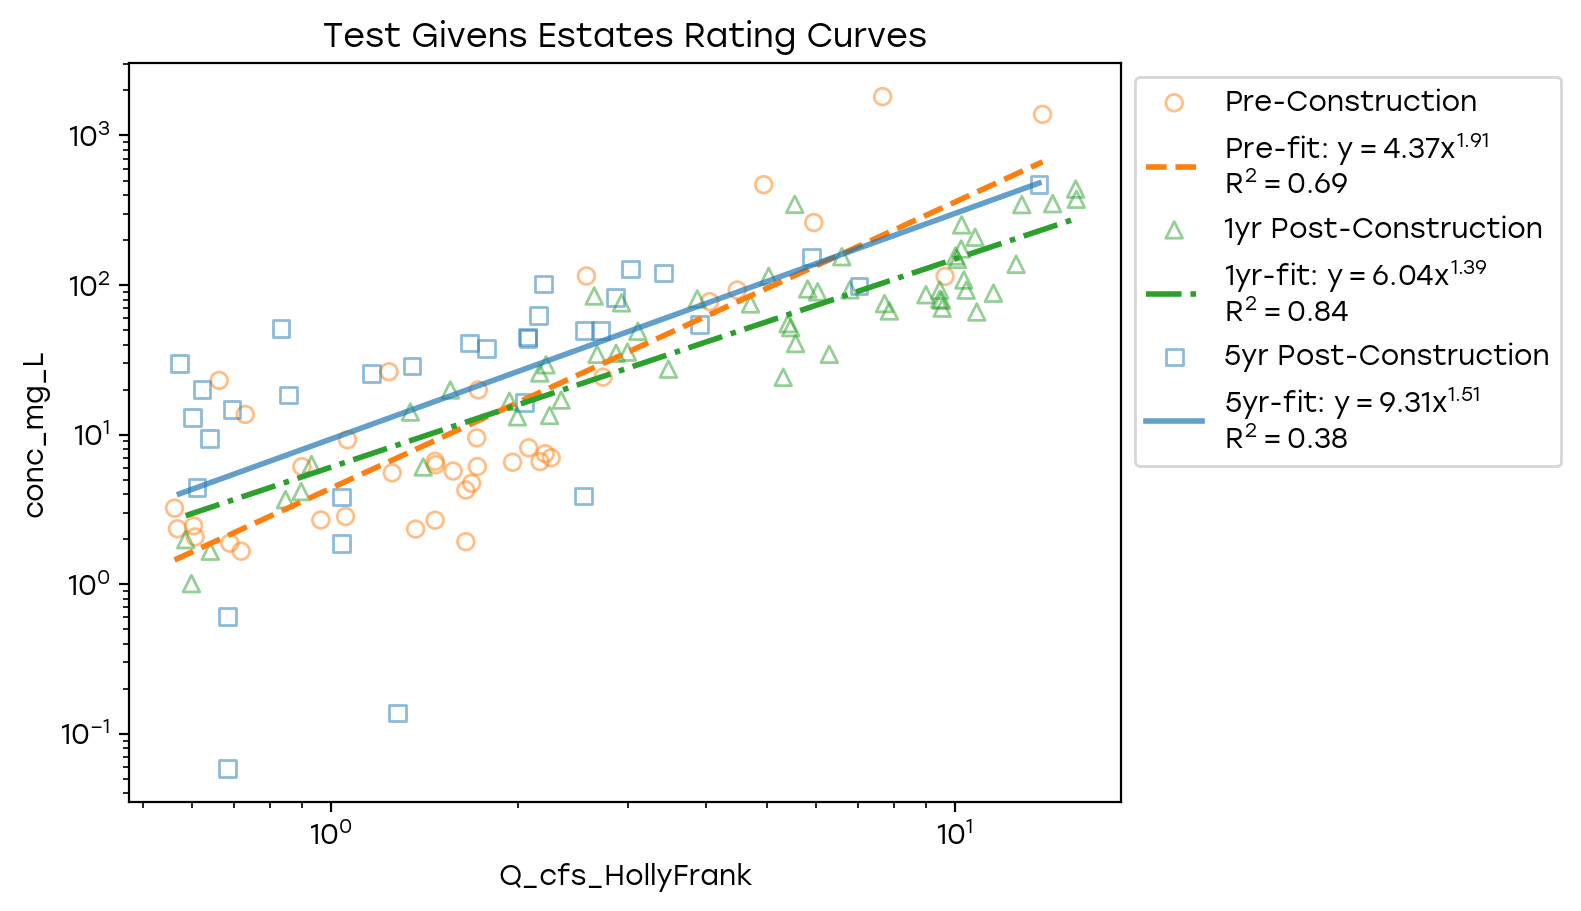

In [61]:
# trying other rating curves

# create sediment rating curves (e.g., log-log plot of Load [g/s] vs. Q [cfs] with line of best fit and R^2])
# create dataframe for plot - only where ISCO was sampled
rating_curve_df = stage_sed_df.copy()
rating_curve_df = rating_curve_df.dropna(subset=['conc_mg_L'])
rating_curve_df = rating_curve_df[rating_curve_df['stage_corrected_ft'] > 0.45] # take out measurements below recommended minimum depth for v-notch weir

# tests
# rating_curve_df = rating_curve_df[rating_curve_df['Q_cfs_HollyFrank'] > 0.15]
# rating_curve_df = rating_curve_df[(rating_curve_df['date_time_stage'] < np.datetime64('2024-05-18')) | (rating_curve_df['date_time_stage'] >= np.datetime64('2024-05-19'))]
# rating_curve_df = rating_curve_df[(rating_curve_df['date_time_stage'] < np.datetime64('2024-05-23')) | (rating_curve_df['date_time_stage'] >= np.datetime64('2024-05-24'))]

# filter out data excluded in 2019 study
excluded_postExcel = [
    '2019-07-23 11:15',
    '2019-07-23 10:55',
    '2019-07-23 10:45',
    '2019-07-23 10:25',
    '2019-07-23 10:15',
    '2019-07-23 09:55',
    '2019-07-23 09:45',
    '2019-07-23 06:55',
    '2019-07-23 07:15',
    '2019-07-23 09:25',
    '2019-07-23 07:25',
    '2019-07-23 07:45',
    '2019-07-23 09:15',
    '2019-07-23 07:55',
    '2019-07-23 08:55',
    '2019-07-23 11:25',
]
rating_curve_df['timestamp_no_seconds'] = rating_curve_df['date_time_isco'].dt.strftime('%Y-%m-%d %H:%M')
rating_curve_df = rating_curve_df[~rating_curve_df['timestamp_no_seconds'].isin(excluded_postExcel)]
rating_curve_df = rating_curve_df.drop(columns=['timestamp_no_seconds'])

# split dataframes in to pre vs. post timeframes
pre_rating_df = rating_curve_df[rating_curve_df['date_time_stage'] < np.datetime64('2019-01-01')]
post_1yr_rating_df = rating_curve_df[(rating_curve_df['date_time_stage'] >= np.datetime64('2019-01-01')) & (rating_curve_df['date_time_stage'] < np.datetime64('2020-01-01'))]
# post_5yr_rating_df = rating_curve_df[rating_curve_df['date_time_stage'] > np.datetime64('2023-01-01')]
post_5yr_rating_df = rating_curve_df[(rating_curve_df['date_time_stage'] > np.datetime64('2023-01-01')) & (rating_curve_df['date_time_stage'] < np.datetime64('2024-08-01'))]

# Q_pre = pre_rating_df['Q_cfs_HollyFrank']
# load_pre = pre_rating_df['load_g_s_HollyFrank']
# Q_1yr = post_1yr_rating_df['Q_cfs_HollyFrank']
# load_1yr = post_1yr_rating_df['load_g_s_HollyFrank']
# Q_5yr = post_5yr_rating_df['Q_cfs_HollyFrank']
# load_5yr = post_5yr_rating_df['load_g_s_HollyFrank']

# Q_pre = pre_rating_df['Q_cfs_SamFrank']
# load_pre = pre_rating_df['load_g_s_SamFrank']
# Q_1yr = post_1yr_rating_df['Q_cfs_SamFrank']
# load_1yr = post_1yr_rating_df['load_g_s_SamFrank']
# Q_5yr = post_5yr_rating_df['Q_cfs_SamFrank']
# load_5yr = post_5yr_rating_df['load_g_s_SamFrank']

# Q_pre = pre_rating_df['Q_cfs_PhilFrank']
# load_pre = pre_rating_df['load_g_s_PhilFrank']
# Q_1yr = post_1yr_rating_df['Q_cfs_PhilFrank']
# load_1yr = post_1yr_rating_df['load_g_s_PhilFrank']
# Q_5yr = post_5yr_rating_df['Q_cfs_PhilFrank']
# load_5yr = post_5yr_rating_df['load_g_s_PhilFrank']

# pre
x = np.array(pre_rating_df['Q_cfs_HollyFrank']).reshape(-1,1)
y = np.array(pre_rating_df['load_g_s_HollyFrank'])
log_x = np.log10(x)
log_y = np.log10(y)
model = LinearRegression().fit(log_x, log_y) # fit_intercept=False
x_plot = np.linspace(min(x), max(x), 100)
y_plot = 10**model.predict(np.log10(x_plot))
log_y_pred = model.predict(log_x)
r_sq = r2_score(log_y, log_y_pred)
print('Pre-Construction:')
print('slope = ', model.coef_[0])
print('intercept = ', model.intercept_)
print('R^2 = ', r_sq)

plt.scatter(x, y, label='Pre-Construction', alpha=0.5, marker='o', facecolors='none', edgecolors='tab:orange')
plt.plot(x_plot, y_plot, ls='--', lw='2', color='tab:orange', label='Pre-fit: $y = {:.2f}x^{{{:.2f}}}$\n$R^2 = {:.2f}$'.format(10**model.intercept_, model.coef_[0], r_sq))

# post 1yr
x = np.array(post_1yr_rating_df['Q_cfs_HollyFrank']).reshape(-1,1)
y = np.array(post_1yr_rating_df['load_g_s_HollyFrank'])
log_x = np.log10(x)
log_y = np.log10(y)
model = LinearRegression().fit(log_x, log_y) # fit_intercept=False
x_plot = np.linspace(min(x), max(x), 100)
y_plot = 10**model.predict(np.log10(x_plot))
log_y_pred = model.predict(log_x)
r_sq = r2_score(log_y, log_y_pred)
print('Pre-Construction:')
print('slope = ', model.coef_[0])
print('intercept = ', model.intercept_)
print('R^2 = ', r_sq)

plt.scatter(x, y, label='1yr Post-Construction', alpha=0.5, marker='^', facecolors='none', edgecolors='tab:green')
plt.plot(x_plot, y_plot, ls='-.', lw='2', color='tab:green', label='1yr-fit: $y = {:.2f}x^{{{:.2f}}}$\n$R^2 = {:.2f}$'.format(10**model.intercept_, model.coef_[0], r_sq))

# post 5yr
x = np.array(post_5yr_rating_df['Q_cfs_HollyFrank']).reshape(-1,1)
y = np.array(post_5yr_rating_df['load_g_s_HollyFrank'])
log_x = np.log10(x)
log_y = np.log10(y)
model = LinearRegression().fit(log_x, log_y) # fit_intercept=False
x_plot = np.linspace(min(x), max(x), 100)
y_plot = 10**model.predict(np.log10(x_plot))
log_y_pred = model.predict(log_x)
r_sq = r2_score(log_y, log_y_pred)
print('Pre-Construction:')
print('slope = ', model.coef_[0])
print('intercept = ', model.intercept_)
print('R^2 = ', r_sq)

plt.scatter(x, y, label='5yr Post-Construction', alpha=0.5, marker='s', facecolors='none', edgecolors='tab:blue')
plt.plot(x_plot, y_plot, alpha=0.7, ls='-', lw='2', color='tab:blue', label='5yr-fit: $y = {:.2f}x^{{{:.2f}}}$\n$R^2 = {:.2f}$'.format(10**model.intercept_, model.coef_[0], r_sq))

plt.xscale('log')
plt.yscale('log')
# plt.xticks(np.arange(0.1,2.0,0.1))
# plt.xlim([0.2,2.0])
plt.xlabel('Q_cfs_HollyFrank')
plt.ylabel('conc_mg_L')
plt.title('Test Givens Estates Rating Curves')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.savefig('figures/RatingCurve_All3_test.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()


- If leak is present, real higher flows will be measured to be lower due to lower head than there should be over weir crest. These higher flows might carry higher sediment loads - this would result in higher sediment concentrations for low flows when this higher concentration should be for higher flows. This error would result in skewing the trends higher at lower stages/flows.
<br> <br>
- Rising vs. Falling Limb: If sediment spikes on the falling limb, perhaps its due to the ISCO intake placed in the weir stilling pool. Sediment may not be being transported to the pool anymore, but the sediment may still be turbid due to the low velocity in the stilling pool rather than being washed downstream. So maybe at lower flows the sediment skews higher than what the suspended load is?

In [21]:
len(rating_curve_df[(rating_curve_df.date_time_stage.dt.year == 2024) & (rating_curve_df.date_time_stage.dt.month == 7)])
rating_curve_df[(rating_curve_df.date_time_stage.dt.year == 2024) & (rating_curve_df.date_time_stage.dt.month == 7)]

date_time_stage  stage_raw  stage_corrected_ft      date_time_isco  \
172167 2024-07-07 14:27:49     1.2474              1.2474 2024-07-07 14:29:00   
172173 2024-07-07 14:57:49     0.8311              0.8311 2024-07-07 14:58:00   
172188 2024-07-07 16:12:49     0.2710              0.2710 2024-07-07 16:14:00   
172205 2024-07-07 17:37:49     0.2381              0.2381 2024-07-07 17:38:00   

         conc_mg_L  Q_cfs_PhilFrank  Q_cfs_Bergmann  Q_cfs_SamFrank  \
172167  494.486216         4.365059        2.998923        7.027339   
172173  689.108911         1.571556       -2.496237        2.553495   
172188   22.084367         0.097054       -9.889557        0.157397   
172205   25.685786         0.070473      -10.323837        0.114325   

        Q_cfs_HollyFrank  load_g_s_PhilFrank  load_g_s_SamFrank  \
172167          7.027339           61.121150          98.399380   
172173          2.553495           30.666555          49.827612   
172188          0.157397            0.060694           0.098430   
172205          0.114325            0.051258           0.083153   

        load_g_s_HollyFrank  
172167            98.399380  
172173            49.827612  
172188             0.098430  
172205             0.083153

In [22]:
# quick and dirty
isco_events_df = stage_sed_df.copy()

past_yrs_df = isco_events_df[isco_events_df.date_time_stage.dt.year < max(isco_events_df.date_time_stage.dt.year)]
current_yr_df = isco_events_df[isco_events_df.date_time_stage.dt.year == max(isco_events_df.date_time_stage.dt.year)]
cleaned_past_yrs_df = past_yrs_df.dropna(subset='conc_mg_L')
isco_events_df = pd.concat([cleaned_past_yrs_df, current_yr_df]).reset_index(drop=True)
isco_events_df = isco_events_df.dropna(subset=['date_time_isco'])

# filter out data excluded in 2019 study Excel
excluded_postExcel = [
    '2019-07-23 11:15',
    '2019-07-23 10:55',
    '2019-07-23 10:45',
    '2019-07-23 10:25',
    '2019-07-23 10:15',
    '2019-07-23 09:55',
    '2019-07-23 09:45',
    '2019-07-23 06:55',
    '2019-07-23 07:15',
    '2019-07-23 09:25',
    '2019-07-23 07:25',
    '2019-07-23 07:45',
    '2019-07-23 09:15',
    '2019-07-23 07:55',
    '2019-07-23 08:55',
    '2019-07-23 11:25',
]
isco_events_df['timestamp_no_seconds'] = isco_events_df['date_time_isco'].dt.strftime('%Y-%m-%d %H:%M')
isco_events_df = isco_events_df[~isco_events_df['timestamp_no_seconds'].isin(excluded_postExcel)]
isco_events_df = isco_events_df.drop(columns=['timestamp_no_seconds'])
isco_events_df['year'] = isco_events_df.date_time_stage.dt.year

isco_events_df

# rating_curve_df = stage_sed_df.copy()
# rating_curve_df = rating_curve_df.dropna(subset=['conc_mg_L'])
# rating_curve_df = rating_curve_df[rating_curve_df['stage_corrected_ft'] > 0.2] # take out measurements below recommended minimum depth for v-notch weir


date_time_stage  stage_raw  stage_corrected_ft      date_time_isco  \
0     2018-04-15 08:23:00     4.0000            0.333333 2018-04-15 08:23:00   
1     2018-04-15 09:51:00    10.0000            0.833333 2018-04-15 09:51:00   
2     2018-04-15 10:11:00    19.5000            1.625000 2018-04-15 10:11:00   
3     2018-04-15 10:20:00    15.5000            1.291667 2018-04-15 10:20:00   
4     2018-04-15 10:30:00    13.0000            1.083333 2018-04-15 10:30:00   
...                   ...        ...                 ...                 ...   
26777 2024-08-17 17:01:13     0.2403            0.240300 2024-08-17 17:00:00   
26820 2024-08-17 20:36:13     0.1470            0.147000 2024-08-17 20:35:00   
26822 2024-08-17 20:46:13     0.1960            0.196000 2024-08-17 20:45:00   
26824 2024-08-17 20:56:13     0.3116            0.311600 2024-08-17 20:55:00   
26826 2024-08-17 21:06:13     0.2476            0.247600 2024-08-17 21:05:00   

         conc_mg_L  Q_cfs_PhilFrank  Q_cfs_Bergmann  Q_cfs_SamFrank  \
0       355.526316         0.162066       -9.066757        0.262660   
1      1578.807947         1.582126       -2.466757        2.570625   
2      3535.745614         8.786380        7.983243       12.782495   
3      8377.412281         4.770895        3.583243        7.666000   
4      3350.000000         3.054466        0.833243        4.943704   
...            ...              ...             ...             ...   
26777          NaN         0.072093      -10.294797        0.116951   
26820          NaN         0.021490      -11.526357        0.034866   
26822          NaN         0.043599      -10.879557        0.070742   
26824          NaN         0.137128       -9.353637        0.222290   
26826          NaN         0.077628      -10.198437        0.125921   

       Q_cfs_HollyFrank  load_g_s_PhilFrank  load_g_s_SamFrank  \
0              0.262660            1.631591           2.644317   
1              2.570625           70.732275         114.925223   
2             13.828894          879.707376        1279.805281   
3              7.666000         1131.766967        1818.553026   
4              4.943704          289.752571         468.969362   
...                 ...                 ...                ...   
26777          0.116951                 NaN                NaN   
26820          0.034866                 NaN                NaN   
26822          0.070742                 NaN                NaN   
26824          0.222290                 NaN                NaN   
26826          0.125921                 NaN                NaN   

       load_g_s_HollyFrank  year  
0                 2.644317  2018  
1               114.925223  2018  
2              1384.572535  2018  
3              1818.553026  2018  
4               468.969362  2018  
...                    ...   ...  
26777                  NaN  2024  
26820                  NaN  2024  
26822                  NaN  2024  
26824                  NaN  2024  
26826                  NaN  2024  

[294 rows x 13 columns]

In [23]:
# len(isco_events_df[(isco_events_df.date_time_stage.dt.year == 2024) & (isco_events_df.date_time_stage.dt.month == 7)])
# isco_events_df[(isco_events_df.date_time_stage.dt.year == 2024) & (isco_events_df.date_time_stage.dt.month == 7)]

<Figure size 400x300 with 0 Axes>

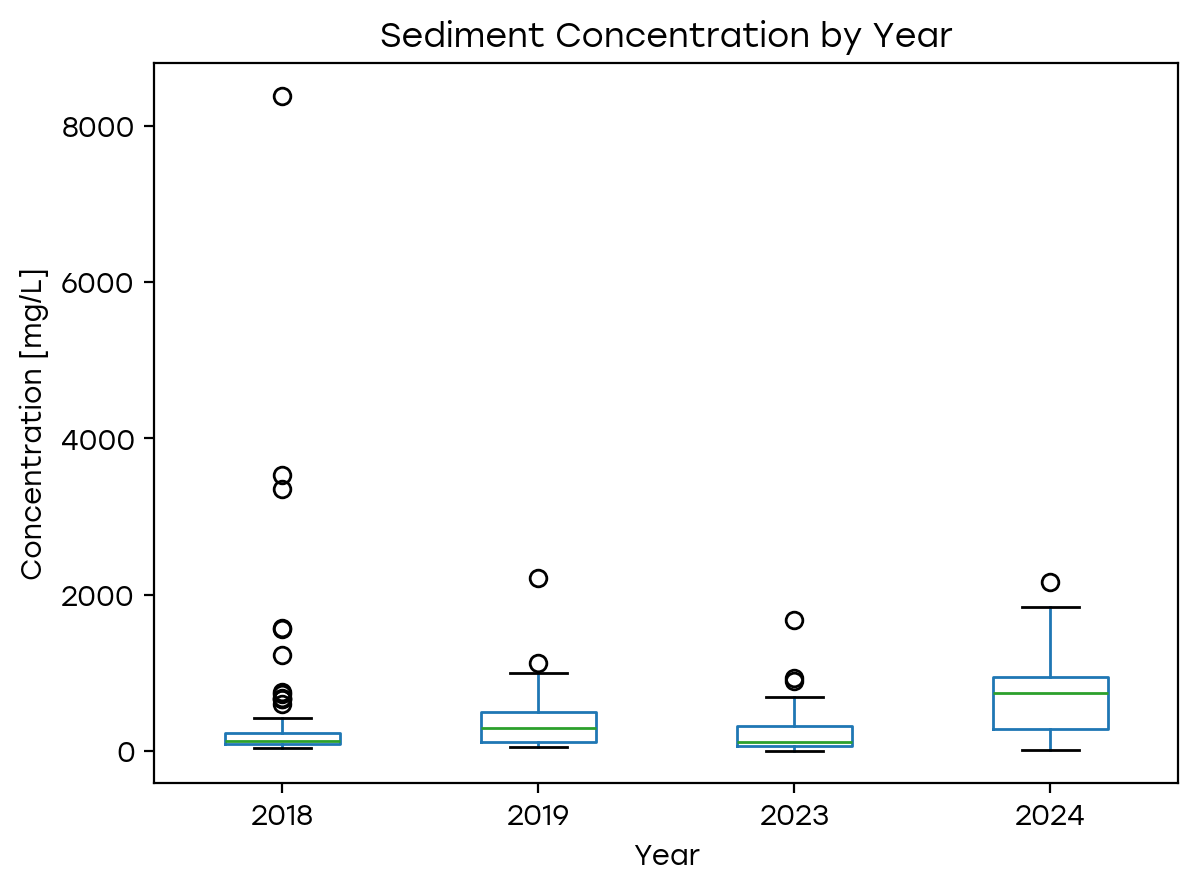

<Figure size 400x300 with 0 Axes>

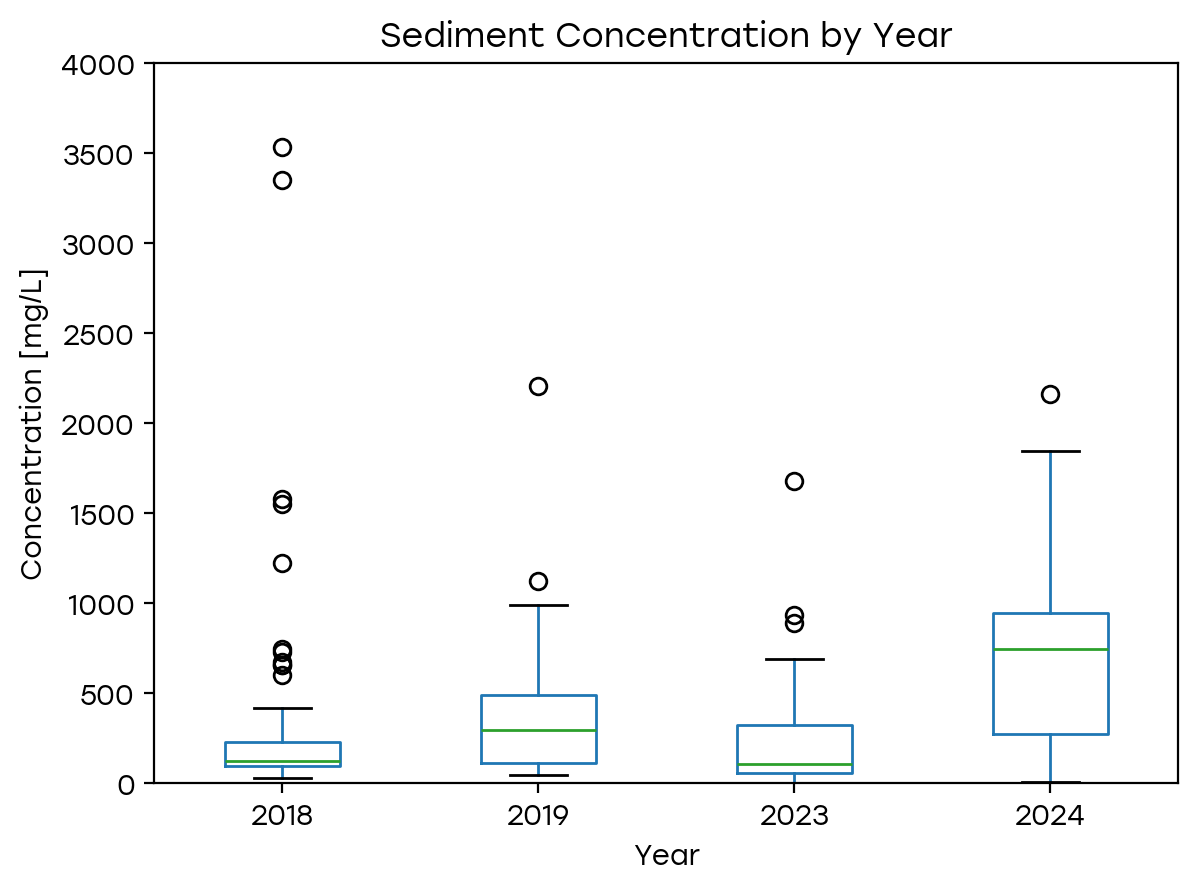

<Figure size 400x300 with 0 Axes>

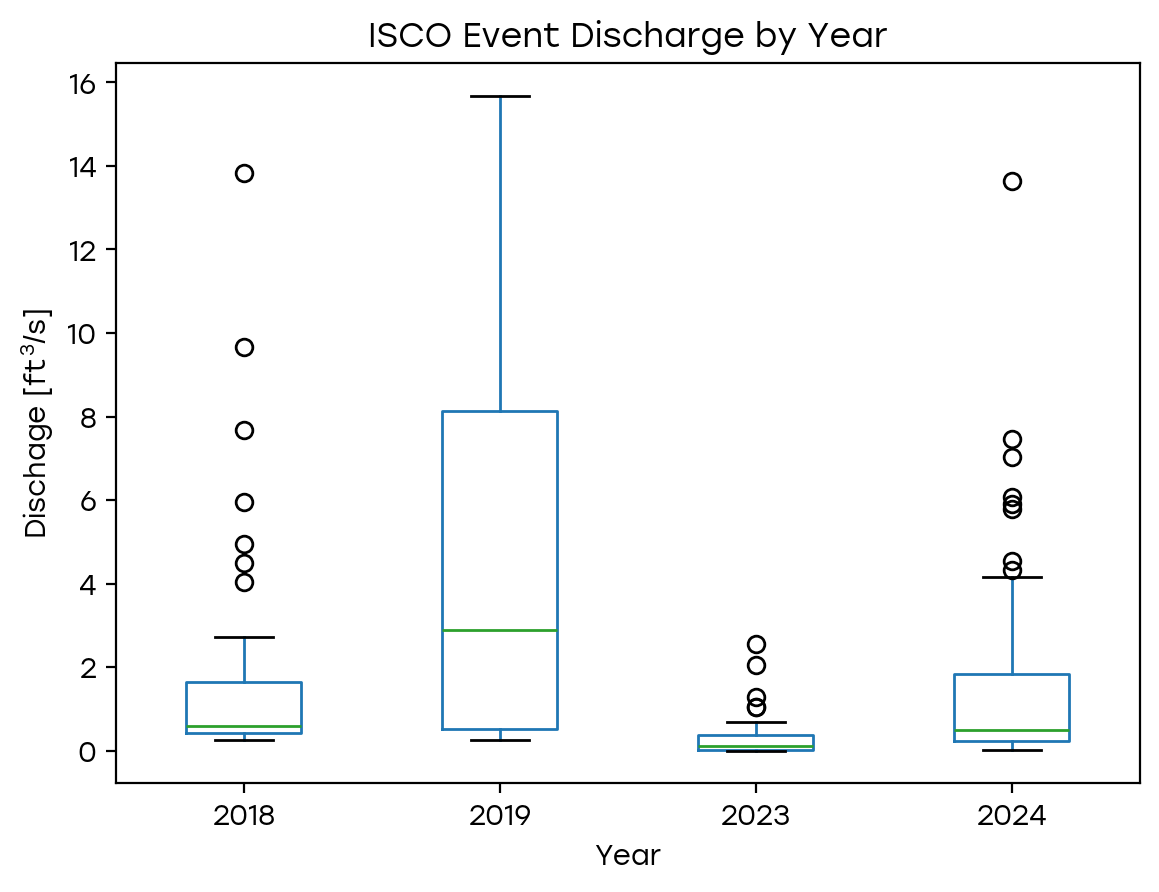

<Figure size 400x300 with 0 Axes>

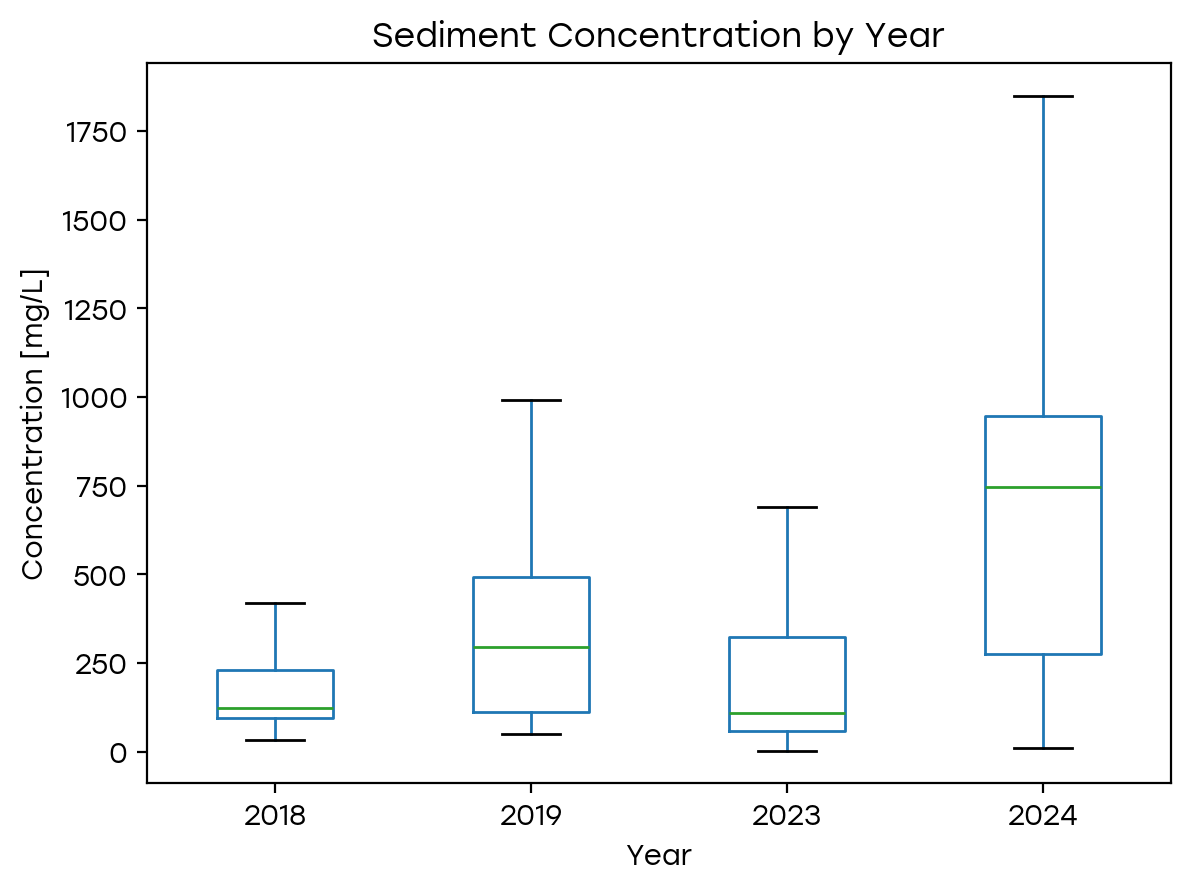

<Figure size 400x300 with 0 Axes>

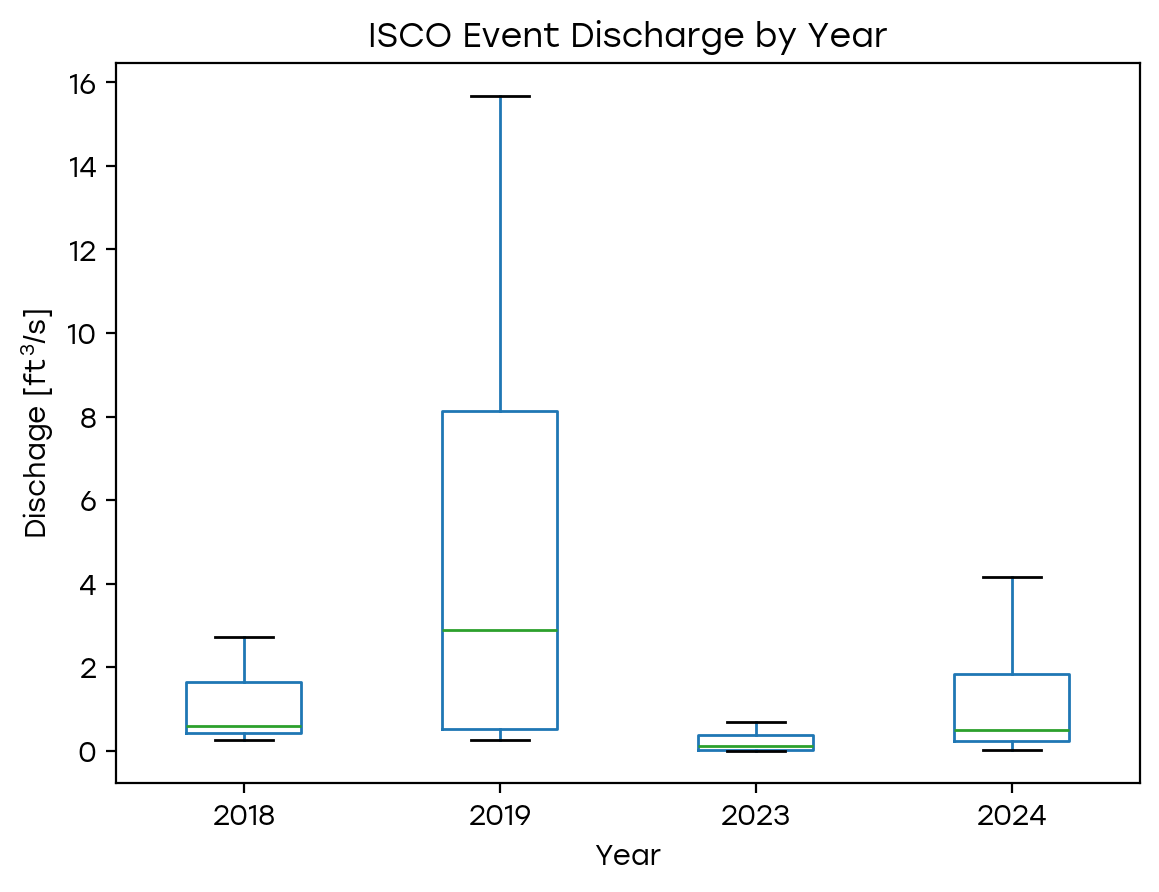

In [25]:
# quick and dirty box and whisker plots conc and discharge

# # WITH OUTLIERS
plt.figure(figsize=(4, 3))

# Group data by year and plot boxplot for 'values'
isco_events_df.boxplot(column='conc_mg_L', by='year', grid=False)
# isco_events_df.boxplot(column='conc_mg_L', by='year', grid=False, showfliers=False)

# Customizing the plot
plt.title('Sediment Concentration by Year')
plt.suptitle('')  # Removes the default title to avoid overlapping
plt.xlabel('Year')
plt.ylabel('Concentration [mg/L]')
plt.ylim()

# Show the plot
# plt.savefig('figures/boxplot_outliers_conc_byYear.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

# zoom in, cut off 8000 mg/L outlier
plt.figure(figsize=(4, 3))

# Group data by year and plot boxplot for 'values'
isco_events_df.boxplot(column='conc_mg_L', by='year', grid=False)
# isco_events_df.boxplot(column='conc_mg_L', by='year', grid=False, showfliers=False)

# Customizing the plot
plt.title('Sediment Concentration by Year')
plt.suptitle('')  # Removes the default title to avoid overlapping
plt.xlabel('Year')
plt.ylabel('Concentration [mg/L]')
plt.ylim([0,4000])

# Show the plot
# plt.savefig('figures/boxplot_outliersNo8000_conc_byYear.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


# discharge
plt.figure(figsize=(4, 3))

# Group data by year and plot boxplot for 'values'
isco_events_df.boxplot(column='Q_cfs_HollyFrank', by='year', grid=False)
# isco_events_df.boxplot(column='conc_mg_L', by='year', grid=False, showfliers=False)

# Customizing the plot
plt.title('ISCO Event Discharge by Year')
plt.suptitle('')  # Removes the default title to avoid overlapping
plt.xlabel('Year')
plt.ylabel('Dischage [$ft^3$/s]')
plt.ylim()

# Show the plot
# plt.savefig('figures/boxplot_outliers_Q_byYear.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()








# # WITH NO OUTLIERS - OUTLIERS ARE REMOVED
plt.figure(figsize=(4, 3))

# Group data by year and plot boxplot for 'values'
# isco_events_df.boxplot(column='conc_mg_L', by='year', grid=False)
isco_events_df.boxplot(column='conc_mg_L', by='year', grid=False, showfliers=False)

# Customizing the plot
plt.title('Sediment Concentration by Year')
plt.suptitle('')  # Removes the default title to avoid overlapping
plt.xlabel('Year')
plt.ylabel('Concentration [mg/L]')
plt.ylim()

# Show the plot
# plt.savefig('figures/boxplot_NOoutliers_conc_byYear.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()



# discharge
plt.figure(figsize=(4, 3))

# Group data by year and plot boxplot for 'values'
# isco_events_df.boxplot(column='Q_cfs_HollyFrank', by='year', grid=False)
isco_events_df.boxplot(column='Q_cfs_HollyFrank', by='year', grid=False, showfliers=False)

# Customizing the plot
plt.title('ISCO Event Discharge by Year')
plt.suptitle('')  # Removes the default title to avoid overlapping
plt.xlabel('Year')
plt.ylabel('Dischage [$ft^3$/s]')
plt.ylim()

# Show the plot
# plt.savefig('figures/boxplot_NOoutliers_Q_byYear.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

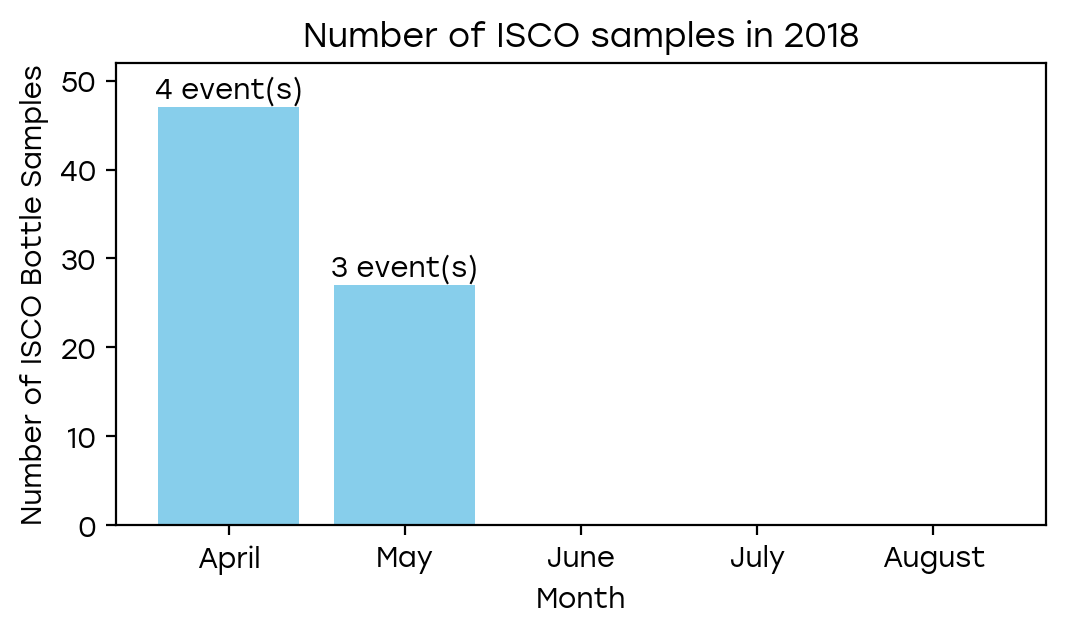

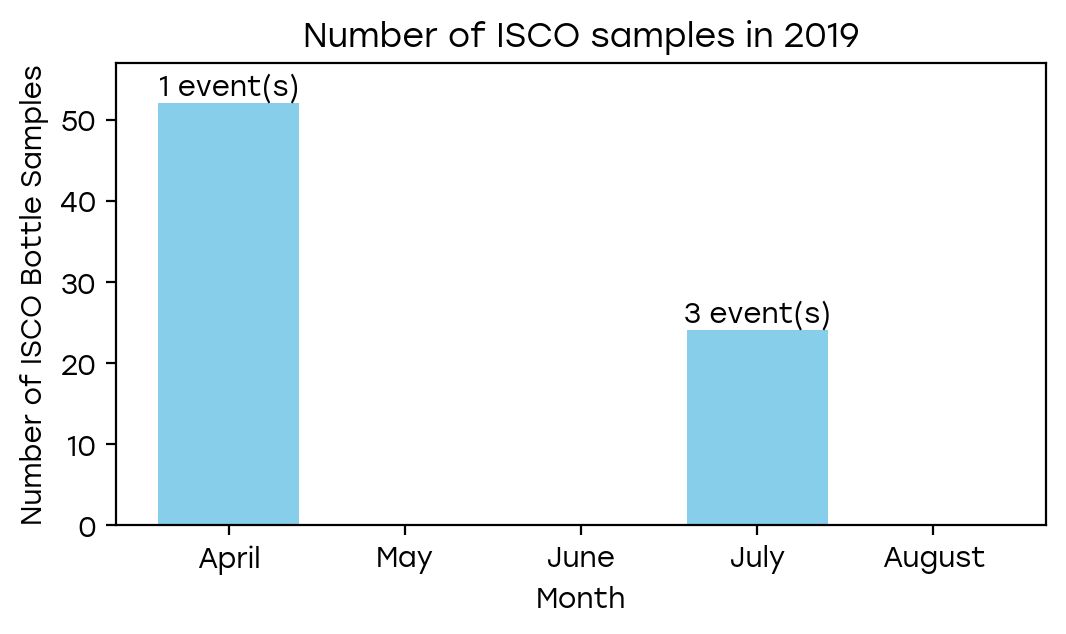

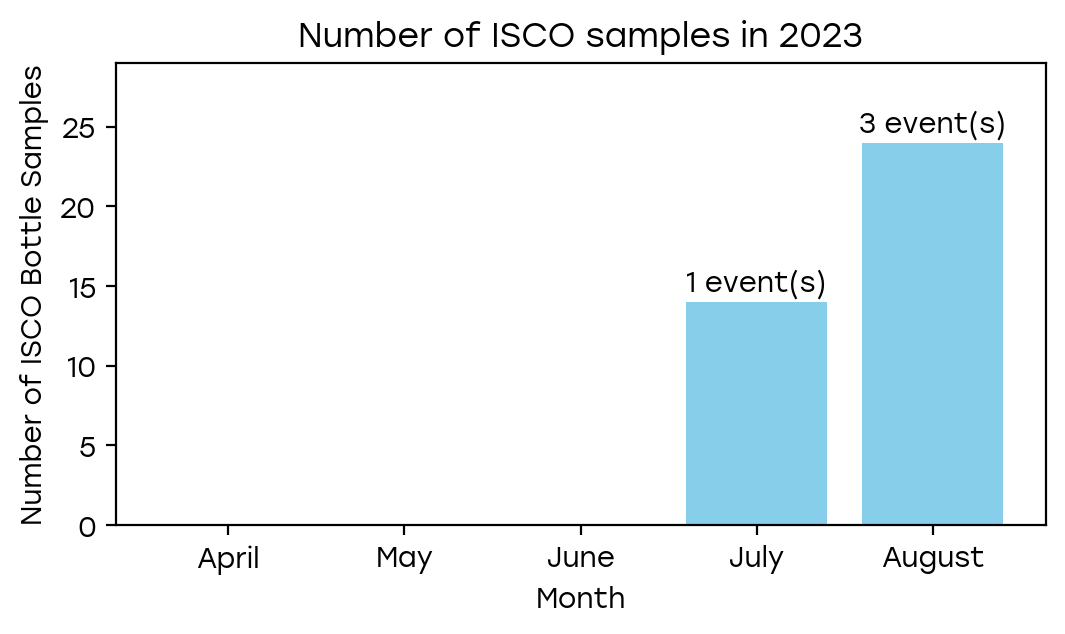

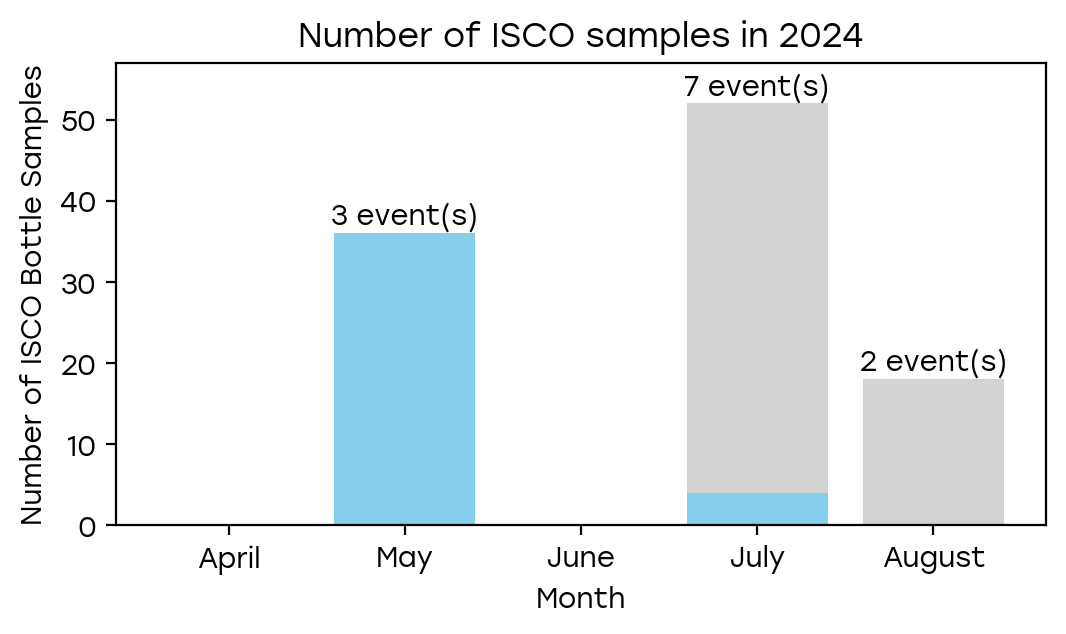

In [26]:
# ChatGPT quick and dirty histograms

# Extract year and month
isco_events_df['year'] = isco_events_df['date_time_stage'].dt.year
isco_events_df['month'] = isco_events_df['date_time_stage'].dt.month

# Get a list of unique years
years = isco_events_df['year'].unique()

# Define the months April (4) to July (7)
months_to_display = [4, 5, 6, 7, 8]
month_names = {4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August'}

# Custom bar segments
custom_bars = {
    (2024, 7): (4, 48),  # June 2023: 4 units blue, 48 units gray
    (2024, 8): (0, 18),
    # Add more as needed
}

# Define arbitrary numbers to display above the bars (for demonstration)
arbitrary_numbers = {
    (2018, 4): 4,  
    (2018, 5): 3, # 3 over May 2018
    (2019, 4): 1,
    (2019, 7): 3,
    (2023, 7): 1,
    (2023, 8): 3,
    (2024, 5): 3,
    (2024, 7): 7,
    (2024, 8): 2, 
    # Add more as needed
}

# Plot for each year
for year in years:
    # Filter data for the current year
    df_year = isco_events_df[isco_events_df['year'] == year]

    # Count rows for each month, ensuring all months from April to July are included
    monthly_counts = df_year['month'].value_counts().reindex(months_to_display, fill_value=0).sort_index()

    # Plot the histogram
    plt.figure(figsize=(6, 3))

    for i, (month, count) in enumerate(monthly_counts.items()):
        if (year, month) in custom_bars:
            # plt.bar(i, count, color='skyblue') # test
            blue_part, gray_part = custom_bars[(year, month)]
            plt.bar(i, blue_part, color='skyblue')
            plt.bar(i, gray_part, bottom=blue_part, color='lightgray')
        else:
            plt.bar(i, count, color='skyblue')

    # # Plot the histogram
    # plt.figure(figsize=(8, 4))
    # monthly_counts.plot(kind='bar', color='skyblue')

    plt.title(f'Number of ISCO samples in {year}')
    plt.xlabel('Month')
    plt.ylabel('Number of ISCO Bottle Samples')
    plt.ylim([0,max(monthly_counts)+5])
    # plt.ylim([0,60])
    plt.xticks(ticks=range(len(months_to_display)), labels=[month_names[m] for m in months_to_display], rotation=0)

    # Annotate arbitrary numbers above the bars
    for i, (month, count) in enumerate(monthly_counts.items()):
        arbitrary_number = arbitrary_numbers.get((year, month))
        if arbitrary_number is not None:
            plt.text(i, count + 0.2, str(arbitrary_number)+' event(s)', ha='center', va='bottom', fontsize=10, color='black')

    # plt.savefig('figures/Box_eventsPerYear_{}.pdf'.format(year), bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()


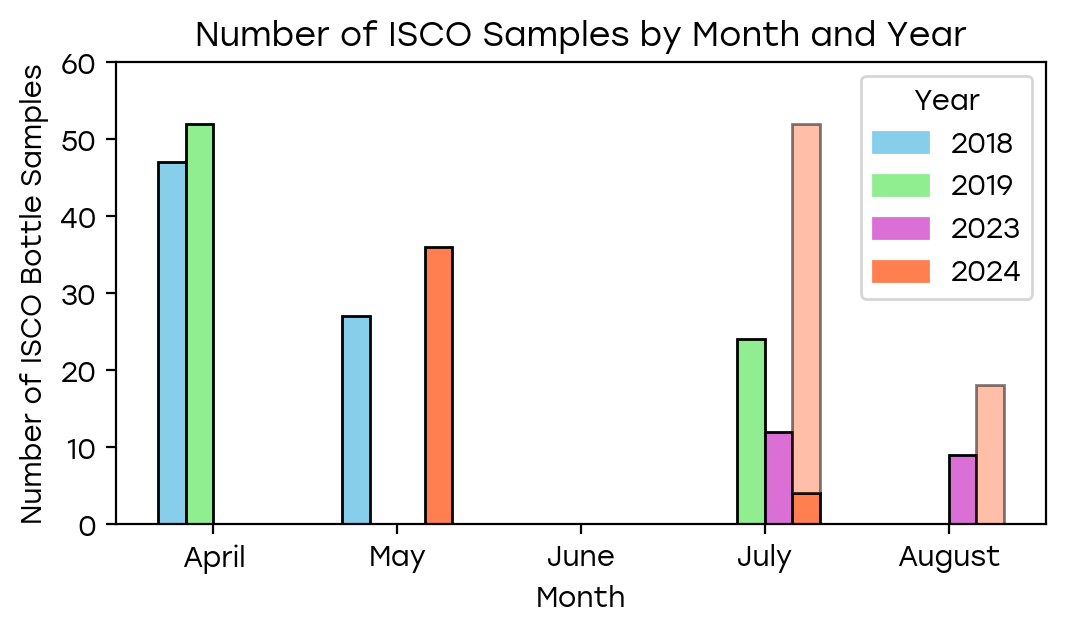

In [27]:
# quick and dirty ChatGPT-assisted barchart number of events

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming rating_curve_df is already defined and loaded with data

# Extract year and month
rating_curve_df['year'] = rating_curve_df['date_time_stage'].dt.year
rating_curve_df['month'] = rating_curve_df['date_time_stage'].dt.month

# Get a list of unique years
years = sorted(rating_curve_df['year'].unique())

# Define the months April (4) to August (8)
months_to_display = [4, 5, 6, 7, 8]
month_names = {4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August'}

# Custom bar segments
custom_bars = {
    (2024, 7): (4, 48),  # July 2024: 4 units blue, 48 units gray
    (2024, 8): (0, 18),  # August 2024: 0 units blue, 18 units gray
}

# Define arbitrary numbers to display above the bars
arbitrary_numbers = {
    (2018, 4): 4,  
    (2018, 5): 3,
    (2019, 4): 1,
    (2019, 7): 3,
    (2023, 7): 1,
    (2023, 8): 3,
    (2024, 5): 3,
    (2024, 7): 7,
    (2024, 8): 2,
}

# Define colors for each year
color_yrs_li = ['skyblue', 'lightgreen', 'orchid', 'coral']

# Aggregate the data by year and month
df_grouped = rating_curve_df.groupby(['year', 'month']).size().unstack(fill_value=0).reindex(columns=months_to_display, fill_value=0)

# Define bar width
bar_width = 0.15
month_indices = np.arange(len(months_to_display))

# Create a grouped bar plot
plt.figure(figsize=(6, 3))

# Create an empty list for legend patches
legend_patches = []

# Plot bars for each year
for i, year in enumerate(years):
    for j, month in enumerate(months_to_display):
        count = df_grouped.at[year, month]
        if (year, month) in custom_bars:
            blue_part, gray_part = custom_bars[(year, month)]
            bar1 = plt.bar(month_indices[j] + i * bar_width, blue_part, width=bar_width, color=color_yrs_li[i], edgecolor='black')
            bar2 = plt.bar(month_indices[j] + i * bar_width, gray_part, bottom=blue_part, width=bar_width, alpha=0.5, color=color_yrs_li[i], edgecolor='black')
        else:
            bar = plt.bar(month_indices[j] + i * bar_width, count, width=bar_width, color=color_yrs_li[i], edgecolor='black')
    
    # Add a patch for the legend
    patch = patches.Patch(color=color_yrs_li[i], label=str(year))
    legend_patches.append(patch)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Number of ISCO Bottle Samples')
plt.title('Number of ISCO Samples by Month and Year')
plt.xticks(month_indices + bar_width * (len(years) - 1) / 2, [month_names[m] for m in months_to_display], rotation=0)
plt.ylim([0, 60])

# Add legend with correct colors
plt.legend(handles=legend_patches, title='Year', loc='upper right', ncol=1, fontsize=10)

# Remove the gridlines
plt.grid(False)

# Show the plot
# plt.savefig('figures/combinedBox_eventsPerYear.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()


In [29]:
# # display(pre_rating_df)
# # display(post_1yr_rating_df)
# pd.set_option('display.max_rows', None)
# # display(isco_events_df.sort_values(by='load_g_s_HollyFrank'))
# display(isco_events_df.sort_values(by='conc_mg_L', ascending=False))
# pd.reset_option('display.max_rows')